# 1. Preprocessing
## 1.1 Package imports and defining path

In [1]:
import numpy as np 
import pandas as pd 
import warnings
import re
import os
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    module=r'pandas\.io\.formats\.format'
)


In [2]:
PATH_ROOT = Path.cwd().parent
PATH_DATA = PATH_ROOT / "data"

In [5]:
eu_country_abbreviations = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czechia': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE'
}

## 1.2 Putting together the dataset
As a first step, we read in the data necessary for our analysis and combine them to a single file. This encompasses data on political parties in Europe over time (party family, vote shares, position on a left-right scale) and economic and demographic country characteristics.
### 1.2.1 Economic and demographic data
The annual **inflation rate** comes from the Harmonized Index of consumer prices (HICP) from Eurostat and depicts year-on-year changes of the average price level, harmonized for all European countries. Inflation is expected to have a strong effect on people's vote choice as price level influences people's lives directly. 


In [6]:
# inflation rate
df_prices = pd.read_csv(PATH_DATA / 'consumer_price_index.csv', low_memory=False)
df_prices = df_prices[(df_prices['coicop'] == 'CP00') & (df_prices['unit'] == 'RCH_A_AVG')] # change in index for all items

PRICES_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_prices = df_prices[PRICES_COLUMNS]
df_prices = (
    df_prices
    .rename(columns={"OBS_VALUE": "inflation_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
# df_prices.head


The **unemployment rate** comes also from Eurostat and measures the yearly share of unemployed persons defined under ILO-standards (without work, actively seeking work, available for work) over the total labor force in the country. The unemployment rate might drive people's economic vote choice strongly as it might be correlated with lower bargaining power, higher poverty and higher crime rates.

In [7]:
df_unemployment = pd.read_csv(PATH_DATA / 'unemployment_rate.csv', low_memory=False)
df_unemployment = df_unemployment[df_unemployment['sex'] == 'T']  # or 'total', check first

UNEMPLOYMENT_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_unemployment = df_unemployment[UNEMPLOYMENT_COLUMNS]

df_unemployment = (
    df_unemployment
    .rename(columns={"OBS_VALUE": "unemployment_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
df_unemployment.head(10)

unemployment_rate
geo year                   
AT  1995                4.4
    1996                5.3
    1997                5.2
    1998                5.5
    1999                4.7
    2000                4.7
    2001                4.0
    2002                4.9
    2003                4.8
    2004                5.8

**Poverty risk** data comes from Eurostat and is here defined as the percentage of population having an equivalized income of less than 60% of the country's median income after social transfers. Again, this might influence economic voting motives with likely similar effects as unemployment rates (higher crime rates, general economic uncertainty).

In [8]:
df_poverty = pd.read_csv(PATH_DATA / 'poverty_risk.csv', low_memory=False)

df_poverty = (
    df_poverty
    .query("age == 'TOTAL'")  # Filter for total only
    .rename(columns={"OBS_VALUE": "poverty_risk"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "age"])
)

df_poverty = df_poverty[['geo', 'year', 'poverty_risk']].set_index(["geo", "year"])
df_poverty.head(10)


poverty_risk
geo year              
AL  2017          23.9
    2018          23.8
    2019          23.8
    2020          22.3
    2021          22.5
    2022          21.1
    2023          20.2
AT  1995          15.0
    1996          16.0
    1997          14.0

The **yearly GDP per capita growth** indicator comes from the World Bank database. It might be tied to the general economic outlook in a country, investment and production activity and, in consequence, be people finding employment and future wage raises.

In [9]:
# yearly gdp growth 
df_gdp = pd.read_csv(PATH_DATA / 'gdp_per_cap.csv', 
                     quoting=3, 
                     engine='python', 
                     encoding='utf-8-sig',
                     on_bad_lines='skip')

df_gdp = df_gdp.reset_index()

year_columns = [str(year) for year in range(1995, 2025)]
GDP_COLUMNS = ["index", "Country Code", "Indicator Name"] + year_columns
df_gdp = df_gdp[GDP_COLUMNS]

# Filter for countries from list above
eu_country_names = list(eu_country_abbreviations.keys())
df_gdp = df_gdp[df_gdp["index"].isin(eu_country_names)]

# long format
df_gdp = df_gdp.rename(columns={"index": "country"})
df_gdp = df_gdp.melt(
    id_vars=["country", "Country Code"], 
    value_vars=year_columns,
    var_name="year", 
    value_name="gdp_per_cap"
)

df_gdp = (
    df_gdp
    .rename(columns={"Country Code": "geo_code"})
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["year"], errors='coerce').astype("Int64"))
    .assign(gdp_per_cap=lambda x: pd.to_numeric(x["gdp_per_cap"], errors='coerce'))
    .set_index(["geo", "year"])
    .drop(columns=["country", "geo_code"])
)

df_gdp.head(20)

gdp_per_cap
geo year             
AT  1995     2.077849
BE  1995     1.123650
BG  1995     5.749370
CY  1995    -0.352430
CZ  1995     4.289888
DE  1995     0.745819
DK  1995     2.315081
ES  1995     2.180924
EE  1995     6.502782
FI  1995     3.323161
FR  1995     1.035285
GR  1995     0.936691
HR  1995     7.574334
HU  1995     0.273327
IE  1995     6.533313
IT  1995     1.317106
LT  1995     5.828553
LU  1995     0.027252
LV  1995     3.458756
MT  1995     3.098244

**Wealth inequality** is measured here as the percentage of total wealth owned by the highest percentile of the wealth distribution. A higher value implies higher wealth inequality. This might impact the working population's perception of fairness and the likeliness of making a good living with one's own work - thus, impacting voting behavior.

In [10]:
# wealth inequality
df_wealth = pd.read_csv(
    PATH_DATA / 'wealth_10p.csv',
    sep=';',
    skiprows=1, 
    on_bad_lines='skip'
) 

new_columns = {}
for col in df_wealth.columns:
    if col in ['Percentile ', 'Year ']:
        new_columns[col] = col.strip()
    else:
        # Extract country name (last part after \n)
        country_name = col.split('\n')[-1]
        new_columns[col] = country_name

df_wealth = df_wealth.rename(columns=new_columns)
df_wealth = df_wealth.drop(columns=['Percentile']) # col not needed
df_wealth = df_wealth.rename(columns={'Year': 'year'})

# Filter countries
eu_country_names = list(eu_country_abbreviations.keys())
available_eu_countries = [col for col in df_wealth.columns if col in eu_country_names]
df_wealth_eu = df_wealth[['year'] + available_eu_countries]

print(f"Found {len(available_eu_countries)} EU countries: {available_eu_countries}")

# Convert to long format
df_wealth_long = df_wealth_eu.melt(
    id_vars=['year'],
    var_name='country',
    value_name='wealth_top10_share'
)

# Convert year to integer and wealth to numeric
df_wealth_long['year'] = pd.to_numeric(df_wealth_long['year'], errors='coerce').astype('Int64')
df_wealth_long['wealth_top10_share'] = pd.to_numeric(df_wealth_long['wealth_top10_share'], errors='coerce')

# Add country code
df_wealth_long['geo'] = df_wealth_long['country'].map(eu_country_abbreviations)

# Set index
df_wealth_long = df_wealth_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_wealth_long.shape}")
df_wealth_long.head()

Found 26 EU countries: ['Slovakia', 'Ireland', 'Lithuania', 'Germany', 'Greece', 'Malta', 'Bulgaria', 'Hungary', 'Italy', 'Austria', 'Spain', 'Croatia', 'Netherlands', 'Romania', 'Luxembourg', 'Slovenia', 'Portugal', 'Sweden', 'France', 'Cyprus', 'Finland', 'Latvia', 'Belgium', 'Denmark', 'Poland', 'Estonia']

Final shape: (780, 1)


wealth_top10_share
geo year                    
SK  1995              0.4174
    1996              0.4174
    1997              0.4175
    1998              0.4178
    1999              0.4181

A country's **debt level** might not impact people's livelihoods directly but the projection of how sustainable the overall welfare system is. It is measured as debt divided by GDP and comes from the IMF's Global Debt Database.

In [11]:
# debt to gdp ratio
df_debt = pd.read_csv(
    PATH_DATA / 'imf_debtToGdp.csv', 
    sep=';',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_debt = df_debt.rename(columns={'General Government Debt (Percent of GDP)': 'country'})

# Filter for EU countries
eu_country_names = list(eu_country_abbreviations.keys())
df_debt = df_debt[df_debt['country'].isin(eu_country_names)]

# Select only years 1995-2024
year_columns = [str(year) for year in range(1995, 2025)]
df_debt = df_debt[['country'] + year_columns]

# Convert to long format
df_debt_long = df_debt.melt(
    id_vars=['country'],
    var_name='year',
    value_name='debt_to_gdp'
)

# Convert year to integer
df_debt_long['year'] = pd.to_numeric(df_debt_long['year'], errors='coerce').astype('Int64')

# Handle the number format: keep only first decimal point, remove the rest
# 68.238.169 -> 68.238169 -> 68.2 (round to 1 decimal)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].replace('no data', None)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].astype(str).str.replace('.', '', regex=False).str[:3]  # Keep first 3 chars
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].apply(lambda x: f"{x[:-1]}.{x[-1]}" if len(x) >= 2 and x != 'Non' else None)
df_debt_long['debt_to_gdp'] = pd.to_numeric(df_debt_long['debt_to_gdp'], errors='coerce')

# Add country code
df_debt_long['geo'] = df_debt_long['country'].map(eu_country_abbreviations)

# Set index
df_debt_long = df_debt_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_debt_long.shape}")
df_debt_long.head(20)


Final shape: (750, 1)


debt_to_gdp
geo year             
AT  1995         68.2
BE  1995         13.1
BG  1995          NaN
HR  1995          NaN
CY  1995         45.8
DK  1995         71.4
EE  1995         86.5
FI  1995         55.2
FR  1995         57.8
DE  1995         55.2
GR  1995         10.0
HU  1995         83.8
IE  1995         78.5
IT  1995         11.9
LV  1995         97.7
LT  1995         11.4
LU  1995         10.2
MT  1995         37.9
NL  1995         73.0
PL  1995         48.7

**Immigration** is an important driver of vote choice, especially for parties with anti-immigration platforms. Data on total immigration inflow comes from Eurostat, and divided by total population (also from Eurostat) to get a relative measure of immigration.

In [12]:
# immigration total
df_immigration = pd.read_csv(
    PATH_DATA / 'immigration_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

IMMIGRATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_immigration = df_immigration[IMMIGRATION_COLUMNS]
df_immigration = (
    df_immigration
    .rename(columns={"OBS_VALUE": "migration_inflow"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_immigration.head(20)


migration_inflow
geo year                  
AT  1996             69930
    1997             70122
    1998             72723
    1999             86710
    2000             81676
    2001             89928
    2002            108125
    2003            111869
    2004            122547
    2005            114465
    2006             98535
    2007             72862
    2008             73772
    2009             69295
    2010             70978
    2011             82230
    2012             91557
    2013            101866
    2014            116262
    2015            166323

**Total population**, as mentioned, also comes from Eurostat and is used to calculate an indicator of relative immigration inflow.

In [13]:
# population total
df_population = pd.read_csv(
    PATH_DATA / 'population_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

POPULATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_population = df_population[POPULATION_COLUMNS]
df_population = (
    df_population
    .rename(columns={"OBS_VALUE": "population_total"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_population.head(100)


population_total
geo     year                  
Andorra 1995             64085
        1996             64169
        1997             64893
        1998             65592
        1999             65924
...                        ...
AT      2014           8546356
        2015           8642699
        2016           8736668
        2017           8797566
        2018           8840521

[100 rows x 1 columns]

The **dependency ratio** is another important indicator for the sustainability of a country's welfare system. It comes from Eurostat and is defined as people under 15 plus over 64 years old (non-working age) divided by the population 15 to 64 years old (working age). A higher dependency ratio therefore means that, per person of working age, there are more people dependent on the social system in some way (schooling, family benefits, pensioneers). Like other measures related to system stability (debt ratio, GDP growth), this might influence peoples voting.

In [14]:
# dependency ratio
df_age_ratio = pd.read_csv(
    PATH_DATA / 'age_ratio.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_age_ratio = df_age_ratio[AGE_COLUMNS]
df_age_ratio = (
    df_age_ratio
    .rename(columns={"OBS_VALUE": "dependency_ratio_15_64"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_age_ratio.head(100)


dependency_ratio_15_64
geo        year                        
Andorra    1995                    35.1
           1996                    36.0
           1997                    36.4
           1998                    36.7
           1999                    36.9
...                                 ...
Azerbaijan 2016                    40.2
           2017                    40.8
           2018                    41.1
           2019                    41.3
           2020                    42.0

[100 rows x 1 columns]

The **median age** in a country is an important variable on population structure. It also comes from Eurostat.

In [15]:
# median age 
df_median_age = pd.read_csv(
    PATH_DATA / 'median_age.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_median_age = df_median_age[AGE_COLUMNS]
df_median_age = (
    df_median_age
    .rename(columns={"OBS_VALUE": "median_age"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_median_age.head(100)


median_age
geo        year            
Andorra    1995        34.1
           1996        34.6
           1997        35.0
           1998        35.5
           1999        35.9
...                     ...
Azerbaijan 2016        30.9
           2017        31.3
           2018        31.8
           2019        32.3
           2020        32.8

[100 rows x 1 columns]

A country population's **educational attainment** levels are also important predictors: Low general levels might lead to stronger support more populist parties. Here, educational attainment is measured by the population percentage of people with upper secondary education or higher according to ISCED 2011. The complement to 100% is, consequently, the share of the population with lower educational attainment. The data comes from Eurostat.

In [16]:
# educational attainment
df_education = pd.read_csv(
    PATH_DATA / 'educational_attainment.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_education = (
    df_education
    .query("`International Standard Classification of Education (ISCED 2011)` == 'Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)'")
    .rename(columns={
        "OBS_VALUE": "ISCED 3-8",
        "Geopolitical entity (reporting)": "country"
    })
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    [['geo', 'year', 'ISCED 3-8']]
    .set_index(['geo', 'year'])
)

df_education.head(10)


ISCED 3-8
geo year           
AT  1995       66.4
    1996       67.7
    1997       69.8
    1998       70.2
    1999       70.7
    2000        NaN
    2001        NaN
    2002        NaN
    2003        NaN
    2004       75.3

The share of population living in **urban conditions** might influence how voters thing about agricultural and environmental issues. The data comes from the World Bank database.

In [17]:
# urban population
df_urban = pd.read_csv(
    PATH_DATA / 'urban_population.csv', 
    sep=',',
    encoding='utf-8-sig',
    skiprows=4,
    quoting=3,
    engine='python',
    on_bad_lines='skip'
)

# clean up some stuff
df_urban = df_urban.reset_index()
df_urban.columns = df_urban.columns.str.replace('"', '', regex=False)
df_urban = df_urban.apply(lambda x: x.str.replace('"', '', regex=False) if x.dtype == 'object' else x)
df_urban = df_urban.rename(columns={'index': 'country'})

# Filter for countries and years
eu_country_names = list(eu_country_abbreviations.keys())
df_urban = df_urban[df_urban['country'].isin(eu_country_names)]
year_columns = [str(year) for year in range(1995, 2025)]
df_urban = df_urban[['country'] + year_columns]

# Convert to long
df_urban_long = df_urban.melt(
    id_vars=['country'],
    var_name='year',
    value_name='urban_population_pct'
)
df_urban_long['year'] = pd.to_numeric(df_urban_long['year'], errors='coerce').astype('Int64')
df_urban_long['urban_population_pct'] = pd.to_numeric(df_urban_long['urban_population_pct'], errors='coerce')


df_urban_long['geo'] = df_urban_long['country'].map(eu_country_abbreviations)
df_urban_long = df_urban_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"Final shape: {df_urban_long.shape}")
df_urban_long.head(20)

Final shape: (780, 1)


urban_population_pct
geo year                      
AT  1995             66.110930
BE  1995             80.684478
BG  1995             67.698196
CY  1995             68.334940
CZ  1995             74.556649
DE  1995             80.054357
DK  1995             85.039203
ES  1995             75.697224
EE  1995             68.447574
FI  1995             65.209822
FR  1995             75.359258
GR  1995             72.179165
HR  1995             55.315560
HU  1995             62.953630
IE  1995             58.174316
IT  1995             66.879392
LT  1995             67.266313
LU  1995             82.617636
LV  1995             68.849553
MT  1995             92.853305

In [18]:
manifesto_filtered = pd.read_csv(
    PATH_DATA / 'manifesto.csv', 
    sep=',',
    encoding='utf-8-sig',
    engine='python',
    on_bad_lines='skip'
)

MANIFESTO_COLUMNS = ['countryname', 'edate', 'partyname', 'pervote',  'party', 'parfam', 'rile', 'planeco', 'welfare', 'markeco', 'per107', 'per202', 'per416_2']
manifesto_filtered = manifesto_filtered[MANIFESTO_COLUMNS]

manifesto_filtered.head()


countryname       edate                       partyname  pervote  party  \
0      Sweden  17/09/1944       Communist Party of Sweden     10.3  11220   
1      Sweden  17/09/1944  Social Democratic Labour Party     46.5  11320   
2      Sweden  17/09/1944                  People’s Party     12.9  11420   
3      Sweden  17/09/1944                     Right Party     15.8  11620   
4      Sweden  17/09/1944                  Agrarian Party     13.6  11810   

   parfam   rile  planeco  welfare  markeco  per107  per202  per416_2  
0      20   9.60      1.9      0.0    1.900     0.0     0.0       NaN  
1      30 -37.80      3.3     33.4    2.200     4.4     1.1       NaN  
2      40   9.50      3.2     14.3    6.400     3.2     6.4       NaN  
3      60  28.00      1.8     10.6   22.800     3.5     0.0       NaN  
4      80  23.81      0.0      0.0   19.048     0.0     0.0       NaN

In [19]:
renaming_map = {
    'partyname': 'party_name',
    'pervote': 'vote_share_percent',
    'countryname': 'country',
    'edate': 'election_date',
    'party': 'party_code',

    'rile': 'right_left_position',
    'planeco': 'planned_economy',
    'welfare': 'welfare_state',
    'markeco': 'market_economy',
    
    'per107': 'inter_positive',
    'per202': 'democracy',    
    'per416_2': 'sustainability_positive', 
    
}
PARFAM = {
    10:  {"abbreviations": "ECO", "label": "Ecological parties"},
    20:  {"abbreviations": "LEF", "label": "Socialist or other left parties"},
    30:  {"abbreviations": "SOC", "label": "Social democratic parties"},
    40:  {"abbreviations": "LIB", "label": "Liberal parties"},
    50:  {"abbreviations": "CHR", "label": "Christian democratic parties (in Israel also Jewish parties)"},
    60:  {"abbreviations": "CON", "label": "Conservative parties"},
    70:  {"abbreviations": "NAT", "label": "Nationalist and radical right parties"},
    80:  {"abbreviations": "AGR", "label": "Agrarian parties"},
    90:  {"abbreviations": "ETH", "label": "Ethnic and regional parties"},
    95:  {"abbreviations": "SIP", "label": "Special issue parties"},
    98:  {"abbreviations": "DIV", "label": "Electoral alliances of diverse origin without dominant party"},
    999: {"abbreviations": "MI",  "label": "Missing information"},
}

manifesto_pre =manifesto_filtered.rename(columns=renaming_map)
manifesto_pre["election_date"] = pd.to_datetime(
    manifesto_pre["election_date"], 
    format='%d/%m/%Y', 
    errors='coerce' 
)           
manifesto_pre["parfam_code"] = manifesto_pre["parfam"].map({k: v["abbreviations"] for k, v in PARFAM.items()})
manifesto_pre["parfam_label"] = manifesto_pre["parfam"].map({k: v["label"] for k, v in PARFAM.items()}) 
manifesto_pre.head(10)


country election_date                      party_name  vote_share_percent  \
0  Sweden    1944-09-17       Communist Party of Sweden              10.300   
1  Sweden    1944-09-17  Social Democratic Labour Party              46.500   
2  Sweden    1944-09-17                  People’s Party              12.900   
3  Sweden    1944-09-17                     Right Party              15.800   
4  Sweden    1944-09-17                  Agrarian Party              13.600   
5  Sweden    1948-09-19       Communist Party of Sweden               6.312   
6  Sweden    1948-09-19  Social Democratic Labour Party              46.132   
7  Sweden    1948-09-19                  People’s Party              22.749   
8  Sweden    1948-09-19                     Right Party              12.343   
9  Sweden    1948-09-19                  Agrarian Party              12.385   

   party_code  parfam  right_left_position  planned_economy  welfare_state  \
0       11220      20                 9.60              1.9            0.0   
1       11320      30               -37.80              3.3           33.4   
2       11420      40                 9.50              3.2           14.3   
3       11620      60                28.00              1.8           10.6   
4       11810      80                23.81              0.0            0.0   
5       11220      20               -44.00              8.0           18.0   
6       11320      30               -33.40              6.7           20.8   
7       11420      40                22.90              2.3            7.0   
8       11620      60                56.30              0.0            0.0   
9       11810      80                -4.90              3.5           13.5   

   market_economy  inter_positive  democracy  sustainability_positive  \
0           1.900             0.0        0.0                      NaN   
1           2.200             4.4        1.1                      NaN   
2           6.400             3.2        6.4                      NaN   
3          22.800             3.5        0.0                      NaN   
4          19.048             0.0        0.0                      NaN   
5           2.000             0.0       10.0                      NaN   
6           5.800             1.7        5.0                      NaN   
7          13.700             1.2        3.4                      NaN   
8          50.000             0.0        3.1                      NaN   
9           9.200             0.0        2.1                      NaN   

  parfam_code                     parfam_label  
0         LEF  Socialist or other left parties  
1         SOC        Social democratic parties  
2         LIB                  Liberal parties  
3         CON             Conservative parties  
4         AGR                 Agrarian parties  
5         LEF  Socialist or other left parties  
6         SOC        Social democratic parties  
7         LIB                  Liberal parties  
8         CON             Conservative parties  
9         AGR                 Agrarian parties

In [20]:
eu_countries = [
    'Austria',
    'Belgium',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czechia',
    'Denmark',
    'Estonia',
    'Finland',
    'France',
    'Germany',
    'Greece',
    'Hungary',
    'Ireland',
    'Italy',
    'Latvia',
    'Lithuania',
    'Luxembourg',
    'Malta',
    'Netherlands',
    'Poland',
    'Portugal',
    'Romania',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Sweden'
]
manifesto_eu = manifesto_pre.loc[manifesto_pre["country"].isin(eu_countries)].copy()
manifesto_eu["geo"] = manifesto_eu["country"].map(eu_country_abbreviations)
manifesto_eu["election_date"] = pd.to_datetime(manifesto_eu["election_date"])
manifesto_eu["year"] = manifesto_eu["election_date"].dt.year
manifesto_eu.head(10)

country election_date                      party_name  vote_share_percent  \
0  Sweden    1944-09-17       Communist Party of Sweden              10.300   
1  Sweden    1944-09-17  Social Democratic Labour Party              46.500   
2  Sweden    1944-09-17                  People’s Party              12.900   
3  Sweden    1944-09-17                     Right Party              15.800   
4  Sweden    1944-09-17                  Agrarian Party              13.600   
5  Sweden    1948-09-19       Communist Party of Sweden               6.312   
6  Sweden    1948-09-19  Social Democratic Labour Party              46.132   
7  Sweden    1948-09-19                  People’s Party              22.749   
8  Sweden    1948-09-19                     Right Party              12.343   
9  Sweden    1948-09-19                  Agrarian Party              12.385   

   party_code  parfam  right_left_position  planned_economy  welfare_state  \
0       11220      20                 9.60              1.9            0.0   
1       11320      30               -37.80              3.3           33.4   
2       11420      40                 9.50              3.2           14.3   
3       11620      60                28.00              1.8           10.6   
4       11810      80                23.81              0.0            0.0   
5       11220      20               -44.00              8.0           18.0   
6       11320      30               -33.40              6.7           20.8   
7       11420      40                22.90              2.3            7.0   
8       11620      60                56.30              0.0            0.0   
9       11810      80                -4.90              3.5           13.5   

   market_economy  inter_positive  democracy  sustainability_positive  \
0           1.900             0.0        0.0                      NaN   
1           2.200             4.4        1.1                      NaN   
2           6.400             3.2        6.4                      NaN   
3          22.800             3.5        0.0                      NaN   
4          19.048             0.0        0.0                      NaN   
5           2.000             0.0       10.0                      NaN   
6           5.800             1.7        5.0                      NaN   
7          13.700             1.2        3.4                      NaN   
8          50.000             0.0        3.1                      NaN   
9           9.200             0.0        2.1                      NaN   

  parfam_code                     parfam_label geo  year  
0         LEF  Socialist or other left parties  SE  1944  
1         SOC        Social democratic parties  SE  1944  
2         LIB                  Liberal parties  SE  1944  
3         CON             Conservative parties  SE  1944  
4         AGR                 Agrarian parties  SE  1944  
5         LEF  Socialist or other left parties  SE  1948  
6         SOC        Social democratic parties  SE  1948  
7         LIB                  Liberal parties  SE  1948  
8         CON             Conservative parties  SE  1948  
9         AGR                 Agrarian parties  SE  1948

In [21]:
manifesto_eu.groupby(['geo', 'year'])['vote_share_percent'].sum().reset_index()


geo  year  vote_share_percent
0    AT  1949              94.412
1    AT  1953              94.314
2    AT  1956              95.522
3    AT  1959              96.682
4    AT  1962              96.476
..   ..   ...                 ...
380  SK  2002              83.176
381  SK  2006              88.024
382  SK  2010              88.420
383  SK  2012              85.235
384  SK  2016              91.779

[385 rows x 3 columns]

In [22]:

manifesto_eu = manifesto_eu.sort_values(['geo', 'election_date'])
END_YEAR = 2024

# get all election years per country
election_years_by_country = manifesto_eu.groupby('geo')['year'].apply(lambda x: sorted(x.unique())).to_dict()

def fill_years(group):
    group['year'] = group['year'].astype(int)
    group = group.drop_duplicates(subset=['year'])
    
    current_geo = group['geo'].iloc[0]
    current_party = group['party_code'].iloc[0]
    country_elections = election_years_by_country[current_geo]
    
    # Get years where this party has valid vote share
    party_election_years = sorted(group['year'].tolist())
    
    # Build segments: only fill between consecutive elections where party ran
    segments = []
    for i, start_year in enumerate(party_election_years):
        # Find the next election in the country
        next_country_elections = [y for y in country_elections if y > start_year]
        
        if i + 1 < len(party_election_years):
            # There's another election where this party ran
            next_party_election = party_election_years[i + 1]
            # Check if there was a country election in between where party didn't run
            elections_between = [y for y in next_country_elections if y < next_party_election]
            if elections_between:
                # Stop at the first election where party didn't run
                end_year = elections_between[0]
            else:
                end_year = next_party_election
        else:
            # This is the party's last election
            if next_country_elections:
                # Party didn't run in next election, stop there
                end_year = next_country_elections[0]
            else:
                # Party ran in most recent election, extend to END_YEAR
                end_year = END_YEAR + 1
        
        segments.append((start_year, end_year))
    
    # Build the filled dataframe from segments
    filled_dfs = []
    for start_year, end_year in segments:
        segment_data = group[group['year'] == start_year].copy()
        full_years = pd.RangeIndex(start_year, end_year, name='year')
        segment_data = segment_data.set_index('year').reindex(full_years)
        segment_data['geo'] = current_geo
        segment_data['party_code'] = current_party
        segment_data = segment_data.ffill()
        filled_dfs.append(segment_data.reset_index())
    
    return pd.concat(filled_dfs, ignore_index=True)

# Apply
manifesto_eu_valid = manifesto_eu.dropna(subset=['vote_share_percent']) # remove parties with NAN vote share (the changed name or ran in coalitions, might be double-counted otherwise)
manifesto_eu_filled = manifesto_eu_valid.groupby(['geo', 'party_code'], group_keys=False).apply(fill_years)
manifesto_eu_filled = manifesto_eu_filled.sort_values(['geo', 'year', 'party_name']).reset_index(drop=True)

/var/folders/72/4mfr23zn6rl6yvskrt7mr9tc0000gn/T/ipykernel_34847/1287594546.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  manifesto_eu_filled = manifesto_eu_valid.groupby(['geo', 'party_code'], group_keys=False).apply(fill_years)


In [23]:
vote_sums_raw = manifesto_eu_filled.groupby(['geo', 'year'])['vote_share_percent'].sum().reset_index()
vote_sums_raw.columns = ['geo', 'year', 'total_vote_share']
print(vote_sums_raw.sort_values(['geo', 'year']).to_string())

     geo  year  total_vote_share
0     AT  1949         94.412000
1     AT  1950         94.412000
2     AT  1951         94.412000
3     AT  1952         94.412000
4     AT  1953         94.314000
5     AT  1954         94.314000
6     AT  1955         94.314000
7     AT  1956         95.522000
8     AT  1957         95.522000
9     AT  1958         95.522000
10    AT  1959         96.682000
11    AT  1960         96.682000
12    AT  1961         96.682000
13    AT  1962         96.476000
14    AT  1963         96.476000
15    AT  1964         96.476000
16    AT  1965         96.476000
17    AT  1966         96.267000
18    AT  1967         96.267000
19    AT  1968         96.267000
20    AT  1969         96.267000
21    AT  1970         98.636000
22    AT  1971         98.604000
23    AT  1972         98.604000
24    AT  1973         98.604000
25    AT  1974         98.604000
26    AT  1975         98.775000
27    AT  1976         98.775000
28    AT  1977         98.775000
29    AT  

In [24]:
# List all variables that are DataFrames
dataframes = {name: obj.shape for name, obj in globals().items() 
              if isinstance(obj, pd.DataFrame) and not name.startswith('_')}

print("Available dataframes:")
for name, shape in sorted(dataframes.items()):
    print(f"  {name}: {shape}")

Available dataframes:
  df_age_ratio: (6292, 1)
  df_debt: (25, 31)
  df_debt_long: (750, 1)
  df_education: (984, 1)
  df_gdp: (780, 1)
  df_immigration: (889, 1)
  df_median_age: (1453, 1)
  df_population: (1617, 1)
  df_poverty: (5190, 1)
  df_prices: (1165, 1)
  df_unemployment: (997, 1)
  df_urban: (26, 31)
  df_urban_long: (780, 1)
  df_wealth: (30, 263)
  df_wealth_eu: (30, 27)
  df_wealth_long: (780, 1)
  manifesto_eu: (2720, 17)
  manifesto_eu_filled: (9567, 17)
  manifesto_eu_valid: (2655, 17)
  manifesto_filtered: (5285, 13)
  manifesto_pre: (5285, 15)
  vote_sums_raw: (1415, 3)


In [26]:
right_dfs = [df_poverty, 
             df_gdp, 
             df_prices, 
             df_unemployment, 
             df_age_ratio,
             df_debt_long,
             df_education,
             df_immigration,
             df_median_age,
             df_population,
             df_urban_long,
             df_wealth_long]

manifesto_fin = manifesto_eu_filled.set_index(["geo", "year"])
merged_df = manifesto_fin

# Perform sequential left merges
for right_df in right_dfs:
    # Remove duplicates from right dataframe before merging
    right_df_clean = right_df[~right_df.index.duplicated(keep='first')]
    
    merged_df = pd.merge(
        left=merged_df,
        right=right_df_clean,
        how='left',
        left_index=True, 
        right_index=True,                  
        suffixes=('', '_new_data')        
    )
merged_df = merged_df.sort_index(level=['geo', 'year'])

merged_df["rel_immigration"] = 100*merged_df["migration_inflow"]/merged_df["population_total"]
merged_df.head(2000)

country election_date                        party_name  \
geo year                                                            
AT  1949  Austria    1949-10-09           Austrian People’s Party   
    1949  Austria    1949-10-09  Austrian Social Democratic Party   
    1949  Austria    1949-10-09            League of Independents   
    1950  Austria    1949-10-09           Austrian People’s Party   
    1950  Austria    1949-10-09  Austrian Social Democratic Party   
...           ...           ...                               ...   
DK  1978  Denmark    1977-02-15       Danish Social-Liberal Party   
    1978  Denmark    1977-02-15                     Justice Party   
    1978  Denmark    1977-02-15              Left Socialist Party   
    1978  Denmark    1977-02-15                          Liberals   
    1978  Denmark    1977-02-15                    Progress Party   

          vote_share_percent  party_code  parfam  right_left_position  \
geo year                                                                
AT  1949              44.032       42520    50.0                 32.2   
    1949              38.713       42320    30.0                -13.6   
    1949              11.667       42420    70.0                  4.7   
    1950              44.032       42520    50.0                 32.2   
    1950              38.713       42320    30.0                -13.6   
...                      ...         ...     ...                  ...   
DK  1978               3.648       13410    40.0                -12.7   
    1978               3.288       13952    95.0                  7.5   
    1978               2.693       13210    20.0                -22.2   
    1978              11.967       13420    40.0                 20.5   
    1978              14.609       13951    70.0                  8.9   

          planned_economy  welfare_state  market_economy  ...  \
geo year                                                  ...   
AT  1949              0.0           16.0             7.1  ...   
    1949              3.4           11.9             0.0  ...   
    1949              9.7           13.4             5.8  ...   
    1950              0.0           16.0             7.1  ...   
    1950              3.4           11.9             0.0  ...   
...                   ...            ...             ...  ...   
DK  1978              2.1           10.6             0.0  ...   
    1978              5.5            5.5             9.3  ...   
    1978              2.2            6.6             0.0  ...   
    1978              4.1            8.1             9.2  ...   
    1978              0.0            6.3             5.9  ...   

          unemployment_rate  dependency_ratio_15_64  debt_to_gdp ISCED 3-8  \
geo year                                                                     
AT  1949                NaN                     NaN          NaN       NaN   
    1949                NaN                     NaN          NaN       NaN   
    1949                NaN                     NaN          NaN       NaN   
    1950                NaN                     NaN          NaN       NaN   
    1950                NaN                     NaN          NaN       NaN   
...                     ...                     ...          ...       ...   
DK  1978                NaN                     NaN          NaN       NaN   
    1978                NaN                     NaN          NaN       NaN   
    1978                NaN                     NaN          NaN       NaN   
    1978                NaN                     NaN          NaN       NaN   
    1978                NaN                     NaN          NaN       NaN   

         migration_inflow  median_age  population_total  urban_population_pct  \
geo year                                                                        
AT  1949              NaN         NaN               NaN                   NaN   
    1949              NaN         NaN               NaN   

In [27]:
merged_df

country election_date  \
geo year                           
AT  1949   Austria    1949-10-09   
    1949   Austria    1949-10-09   
    1949   Austria    1949-10-09   
    1950   Austria    1949-10-09   
    1950   Austria    1949-10-09   
...            ...           ...   
SK  2024  Slovakia    2016-03-05   
    2024  Slovakia    2016-03-05   
    2024  Slovakia    2016-03-05   
    2024  Slovakia    2016-03-05   
    2024  Slovakia    2016-03-05   

                                             party_name  vote_share_percent  \
geo year                                                                      
AT  1949                        Austrian People’s Party              44.032   
    1949               Austrian Social Democratic Party              38.713   
    1949                         League of Independents              11.667   
    1950                        Austrian People’s Party              44.032   
    1950               Austrian Social Democratic Party              38.713   
...                                                 ...                 ...   
SK  2024          Kotleba – People's Party Our Slovakia               8.044   
    2024                                        Network               5.607   
    2024  Ordinary People and Independent Personalities              11.029   
    2024                          Slovak National Party               8.643   
    2024                                  We Are Family               6.629   

          party_code  parfam  right_left_position  planned_economy  \
geo year                                                             
AT  1949       42520    50.0               32.200            0.000   
    1949       42320    30.0              -13.600            3.400   
    1949       42420    70.0                4.700            9.700   
    1950       42520    50.0               32.200            0.000   
    1950       42320    30.0              -13.600            3.400   
...              ...     ...                  ...              ...   
SK  2024       96720    70.0                8.989            0.000   
    2024       96630    60.0                0.863            1.439   
    2024       96620    60.0               -2.538            0.987   
    2024       96710    70.0               12.948            2.204   
    2024       96725    70.0                2.108            2.108   

          welfare_state  market_economy  ...  unemployment_rate  \
geo year                                 ...                      
AT  1949         16.000           7.100  ...                NaN   
    1949         11.900           0.000  ...                NaN   
    1949         13.400           5.800  ...                NaN   
    1950         16.000           7.100  ...                NaN   
    1950         11.900           0.000  ...                NaN   
...                 ...             ...  ...                ...   
SK  2024         11.236           3.371  ...                5.3   
    2024         21.583           4.173  ...                5.3   
    2024         14.170           2.150  ...                5.3   
    2024          9.642           4.408  ...                5.3   
    2024         15.222           3.044  ...                5.3   

          dependency_ratio_15_64  debt_to_gdp ISCED 3-8 migration_inflow  \
geo year                                                                   
AT  1949                     NaN          NaN       NaN              NaN   
    1949                     NaN          NaN       NaN              NaN   
    1949                     NaN          NaN       NaN              NaN   
    1950                     NaN          NaN       NaN              NaN   
    1950                     NaN          NaN       NaN              NaN   
...                          ...          ...       ...              ...   
SK  2024                    52.3          NaN      87.3              NaN   
    2024                    52.3          NaN  

In [28]:
def election_df(df):
    """
    for each country x election, computes:
        vote shares by party family, 
        the effective number of parties (ENP)
        and Dalton polarization index.
    """
        
    d = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()

    # one row per party per election
    d = (d.dropna(subset=["geo","election_date","party_code","vote_share_percent"])
           .groupby(["geo","election_date","party_code"], as_index=False)
           .agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_score=("right_left_position","first")))

    d["vote share proportion"] = d["voteshare"] / 100.0

    # vote shares by party family
    fam = (d.groupby(["geo","election_date","parfam"])["voteshare"]
             .sum()
             .unstack(fill_value=0)
             .add_prefix("vs_"))

    # fragmentation ENP
    enp = d.groupby(["geo","election_date"])["vote share proportion"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")

    # Dalton polarization
    def dalton(g):
        g = g.dropna(subset=["vote share proportion","lr_score"])
        w, lr_score = g["vote share proportion"].to_numpy(), g["lr_score"].to_numpy()
        return np.nan if len(w) == 0 else float(np.sqrt((w * ((lr_score - (w*lr_score).sum()/w.sum()) / 5)**2).sum()))
    
    pol = (d.groupby(["geo", "election_date"])[["vote share proportion", "lr_score"]].apply(dalton).rename("polarization_dalton"))
    out = pd.concat([fam, enp, pol], axis=1).reset_index()
    out["election_year"] = out["election_date"].dt.year
    out = out.set_index(["geo", "election_year"]).sort_index()
    return out

elections = election_df(merged_df)
elections.head()

election_date  vs_AGR  vs_CHR  vs_CON  vs_DIV  vs_ECO  \
geo election_year                                                         
AT  1949             1949-10-09     0.0  44.032     0.0     0.0     0.0   
    1953             1953-02-22     0.0  41.257     0.0     0.0     0.0   
    1956             1956-05-13     0.0  45.957     0.0     0.0     0.0   
    1959             1959-05-10     0.0  44.192     0.0     0.0     0.0   
    1962             1962-11-18     0.0  45.432     0.0     0.0     0.0   

                   vs_ETH  vs_LEF  vs_LIB  vs_NAT  vs_SIP  vs_SOC  \
geo election_year                                                   
AT  1949              0.0     0.0     0.0  11.667     0.0  38.713   
    1953              0.0     0.0     0.0  10.949     0.0  42.108   
    1956              0.0     0.0     0.0   6.520     0.0  43.045   
    1959              0.0     0.0     0.0   7.704     0.0  44.786   
    1962              0.0     0.0     0.0   7.044     0.0  44.000   

                   fragmentation_enp  polarization_dalton  
geo election_year                                          
AT  1949                    2.798273             4.175644  
    1953                    2.781560             4.244402  
    1956                    2.495366             6.000755  
    1959                    2.488757             3.884319  
    1962                    2.469328             2.629708

In [29]:
# deduplicate: if in a year there were 2 elections, keep the first one
elections_dedup = elections.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'election_year'], keep='first'
).set_index(['geo', 'election_year']).sort_index()

merged_df = merged_df.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'year', 'party_code'], keep='first'
).set_index(['geo', 'year'])

# remove party 34020 (SYRIZA) for years >= 2012 (it merged into 34212)
merged_df = merged_df.reset_index()
merged_df = merged_df[~((merged_df['geo'] == 'GR') & 
                        (merged_df['year'] >= 2012) & 
                        (merged_df['party_code'] == 34020))]
merged_df = merged_df.set_index(['geo', 'year'])

df_correlations = pd.merge(
    left=merged_df.reset_index(),
    right=elections_dedup,
    how='left',
    left_on=['geo', 'year'],
    right_on=['geo', 'election_year']
).set_index(['geo', 'year'])



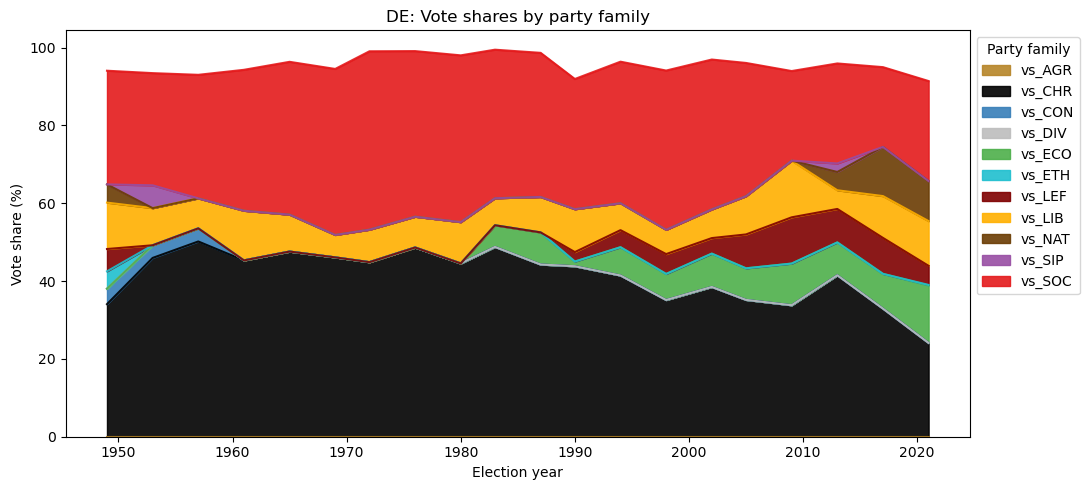

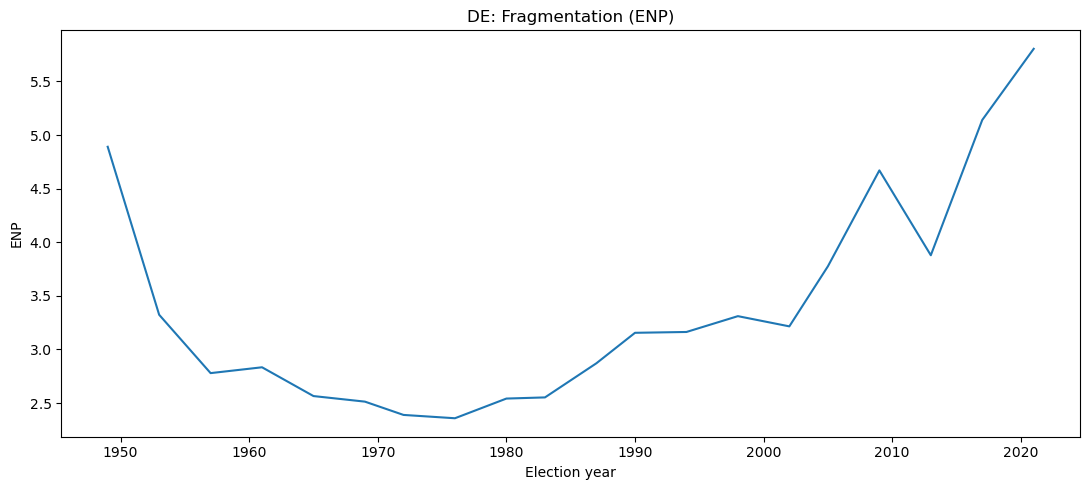

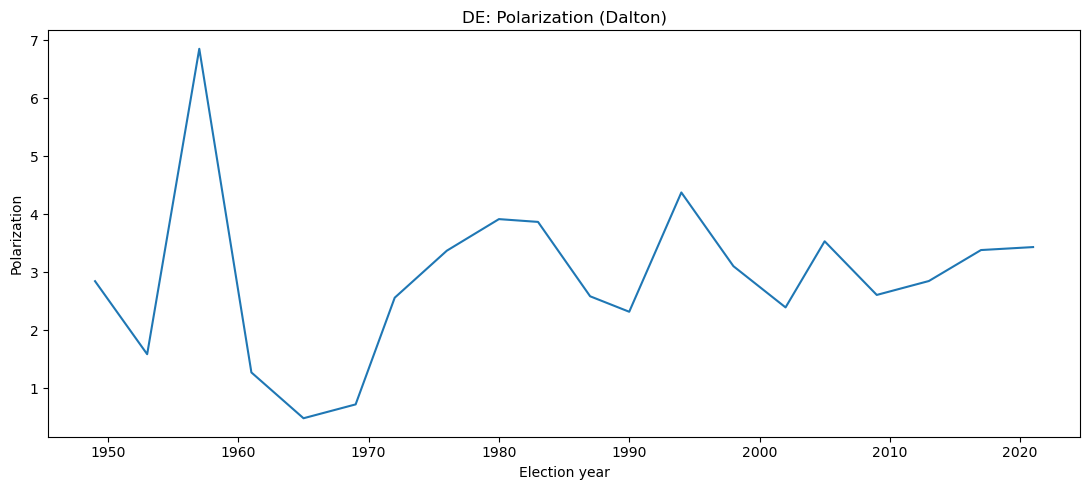

In [30]:
def plot_election_timeseries(countries, elections_df):
    """
    for each country, plots:
        stacked area time series of party-family vote shares,
        time series of fragmentation index and polarization index.
    """

    countries = [c for c in countries if c in elections.index.get_level_values(0)]
    fam = [c for c in elections_df.columns if c.startswith("vs_")]

    for geo in countries:
        d = elections_df.loc[geo].sort_index()

        ax = d[fam].plot.area(stacked=True, figsize=(11,5), alpha=.9, color = FAMILY_COLORS, title=f"{geo}: Vote shares by party family")
        ax.set(xlabel="Election year", ylabel="Vote share (%)")
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), title="Party family")
        plt.tight_layout()
        plt.show()

        ax = d["fragmentation_enp"].plot(figsize=(11,5), title=f"{geo}: Fragmentation (ENP)")
        ax.set(xlabel="Election year", ylabel="ENP")
        plt.tight_layout()
        plt.show()

        ax = d["polarization_dalton"].plot(figsize=(11,5), title=f"{geo}: Polarization (Dalton)")
        ax.set(xlabel="Election year", ylabel="Polarization")
        plt.tight_layout()
        plt.show()

FAMILY_COLORS = {
    "vs_SOC": "#e41a1c",   # Social democratic parties
    "vs_LEF": "#7f0000",   # Socialist or other left parties
    "vs_ECO": "#4daf4a",   # Ecological parties
    "vs_LIB": "#ffb000",   # Liberal parties
    "vs_CHR": "#000000",   # Christian democratic parties
    "vs_CON": "#377eb8",   # Conservative parties
    "vs_NAT": "#6a3c03",   # Nationalist and radical right parties
    "vs_AGR": "#b68528",   # Agrarian parties
    "vs_ETH": "#1fbfcf",   # Ethnic and regional parties
    "vs_SIP": "#984ea3",   # Special issue parties
    "vs_DIV": "#bdbdbd"    # Electoral alliances
}

select_country = ["DE"]
all_countries = sorted(eu_country_abbreviations.values())

# provide all countries or selected countries
plot_election_timeseries(select_country, elections)

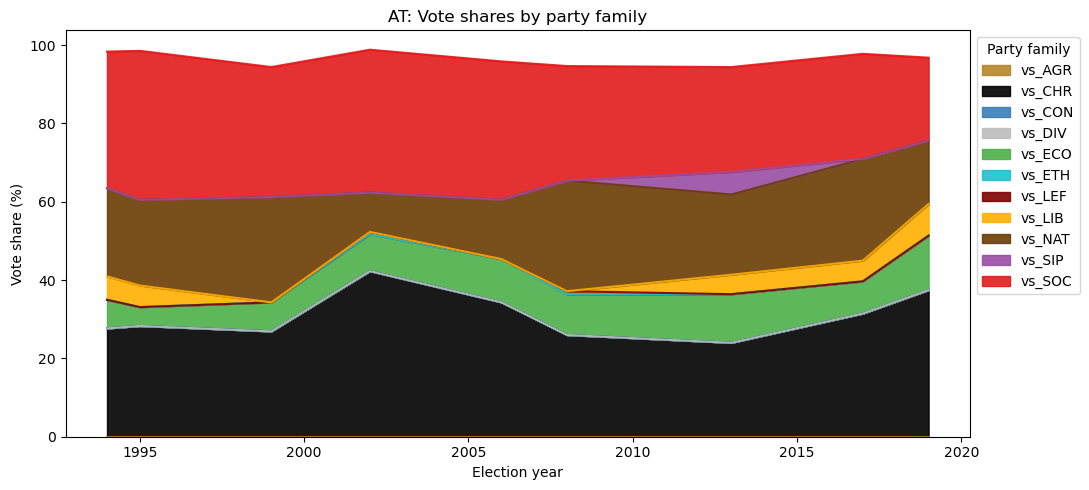

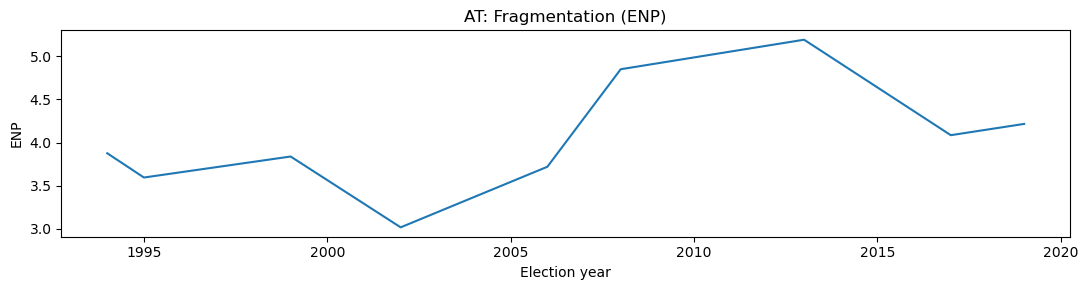

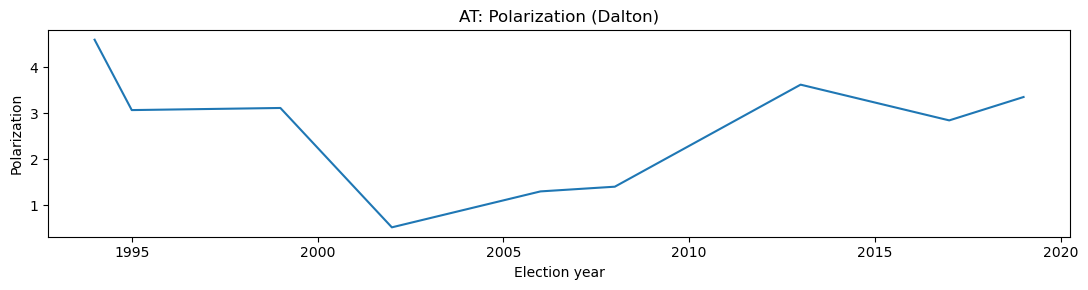


AT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CHR      down 2002–2013       -6.66      -18.31
                SOC      down 1994–2019       -2.26      -13.74
                NAT      down 2008–2019       -1.65      -12.07
                CHR        up 2008–2019        4.74       11.48
                NAT        up 2002–2013        5.90       10.50
                ECO        up 1995–2019        1.21        9.09
                LIB        up 2006–2019        2.23        8.10
                NAT      down 1995–2006       -5.91       -6.74
                CHR        up 1995–2006        5.36        6.04
                LIB      down 1994–2002       -2.87       -5.97
  fragmentation_enp        up 2002–2013        0.82        2.17
  fragmentation_enp      down 2008–2019       -0.43       -0.63
polarization_dalton      down 1994–2006       -0.97       -3.30
polarization_dalton        up 2002–2017        0.77        2.32


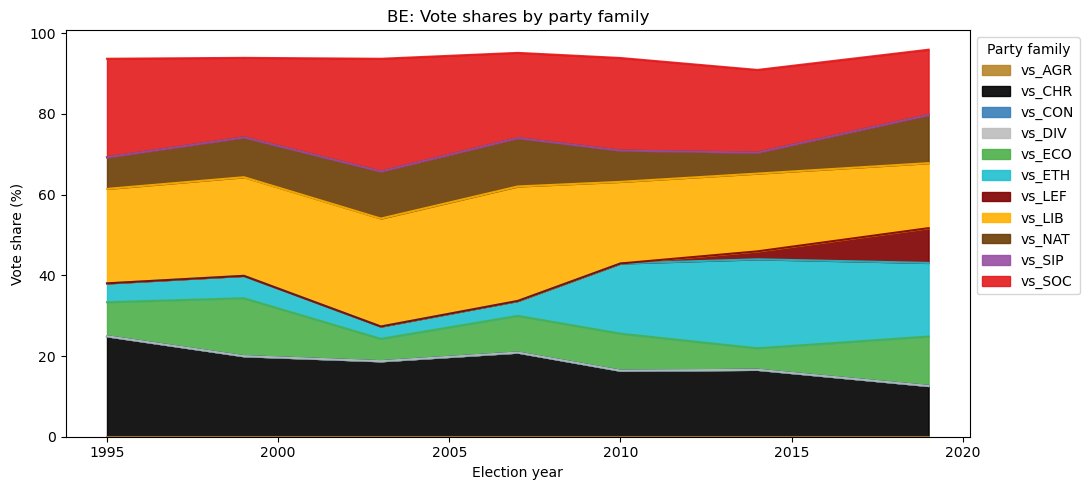

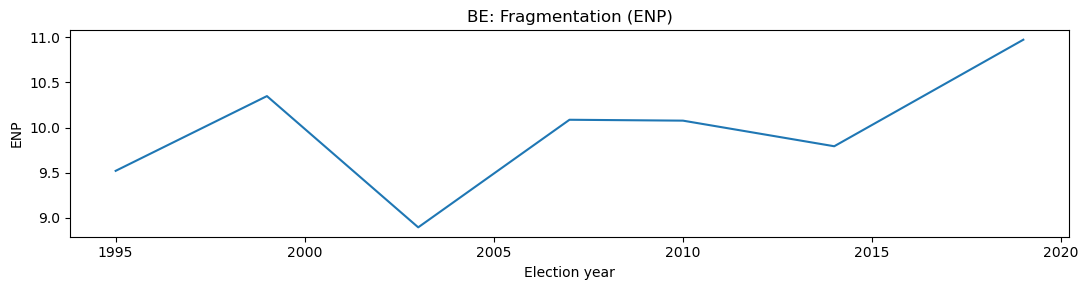

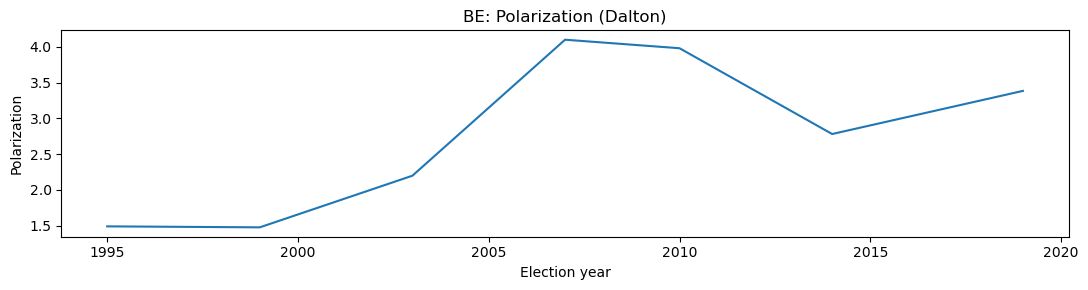


BE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                ETH        up 2003–2019        5.59       15.18
                CHR      down 1995–2019       -2.07      -12.32
                SOC      down 2003–2019       -2.94      -11.76
                LIB      down 2003–2019       -3.29      -10.64
                LEF        up 2007–2019        2.65        8.62
                ECO        up 2003–2019        1.68        6.71
                NAT      down 2003–2014       -2.68       -6.49
                LIB        up 1995–2007        1.82        4.96
                NAT        up 2010–2019        2.09        4.19
                NAT        up 1995–2007        1.49        4.16
  fragmentation_enp        up 2003–2019        0.52        2.08
  fragmentation_enp      down 1995–2003       -0.31       -0.63
polarization_dalton        up 1995–2010        0.85        2.49
polarization_dalton      down 2007–2019       -0.48       -0.72


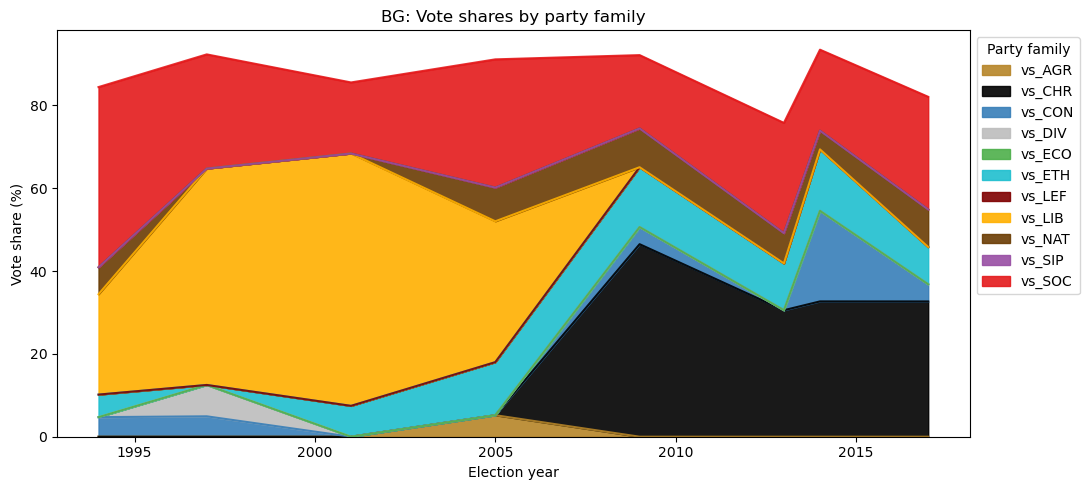

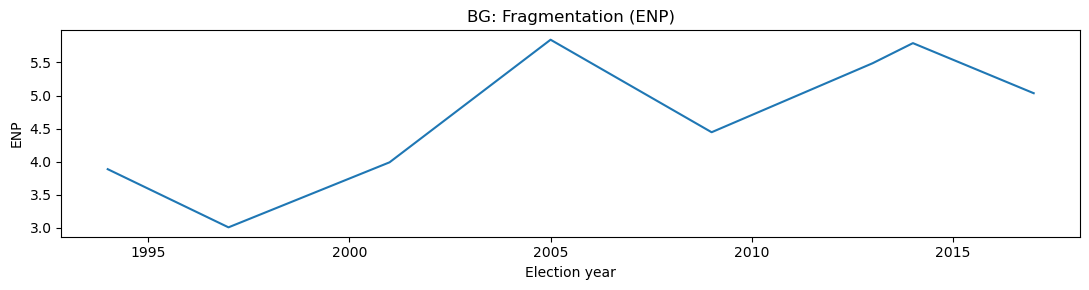

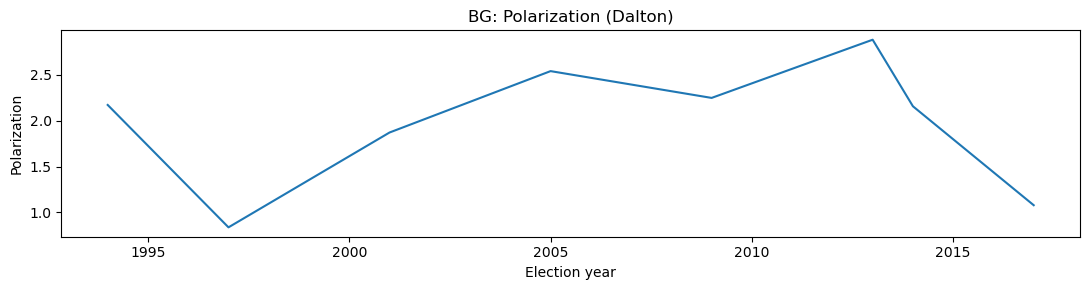


BG — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB      down 1997–2013      -18.86      -52.24
                LIB        up 1994–2001       18.35       36.69
                CHR        up 2001–2017       13.19       32.66
                SOC      down 1994–2001      -13.18      -26.35
                CHR      down 2009–2014       -6.91      -13.81
                NAT        up 1997–2009        4.38        9.36
                ETH        up 1994–2009        3.64        9.00
                DIV      down 1997–2005       -3.78       -7.57
                NAT      down 1994–2001       -3.25       -6.51
                AGR      down 2005–2013       -2.60       -5.19
  fragmentation_enp        up 1997–2014        0.77        2.79
  fragmentation_enp      down 2005–2017       -0.20       -0.81
polarization_dalton        up 1997–2013        0.40        2.05
polarization_dalton      down 2013–2017       -0.90       -1.81


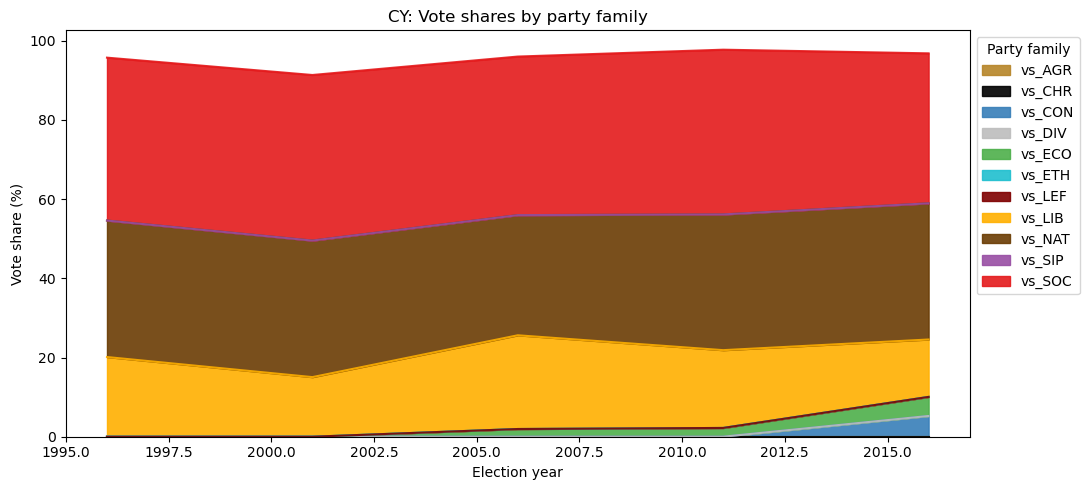

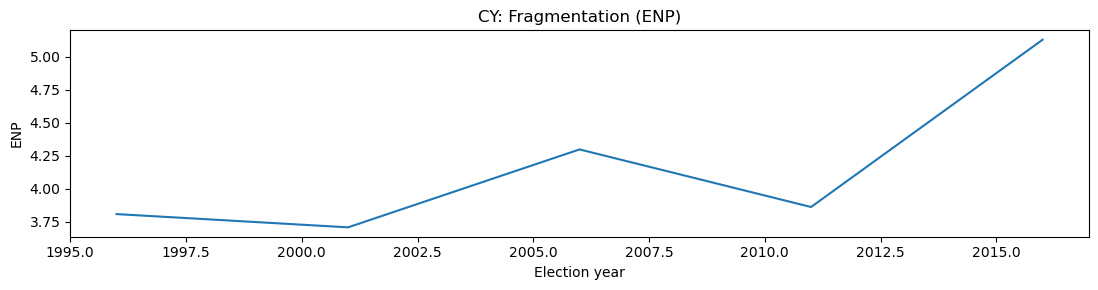

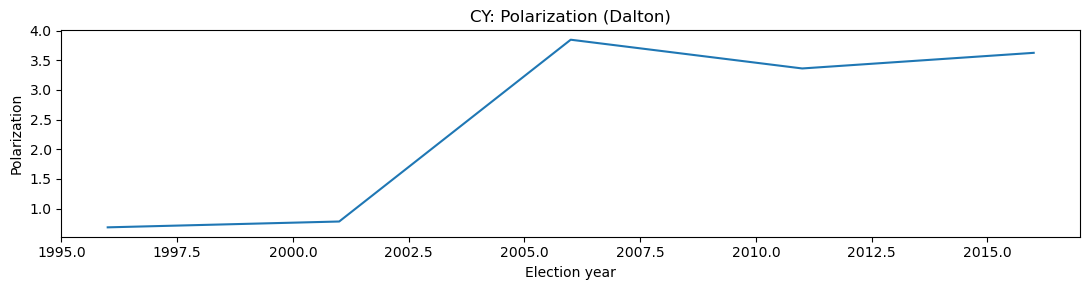


CY — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB      down 2006–2016       -4.59       -9.17
                CON        up 2006–2016        2.62        5.24
                ECO        up 1996–2016        1.17        4.81
                NAT      down 1996–2006       -2.06       -4.13
                NAT        up 2006–2016        2.03        4.05
                SOC      down 1996–2016       -0.82       -3.27
                LIB        up 1996–2011        2.03       -0.48
  fragmentation_enp        up 1996–2016        0.33        1.32
polarization_dalton        up 1996–2011        1.44        2.68


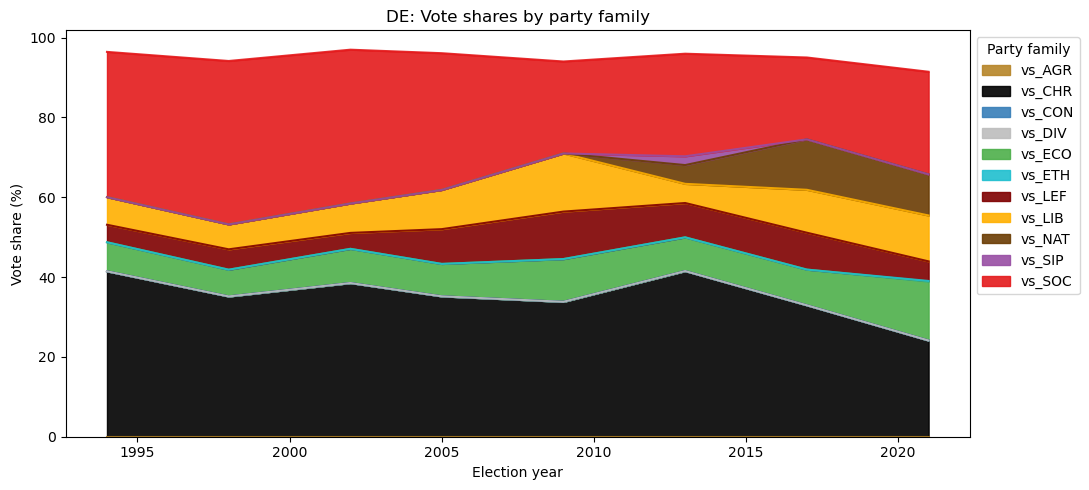

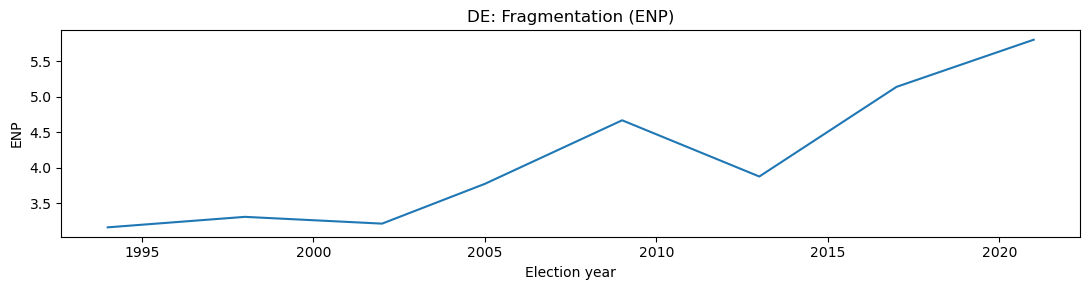

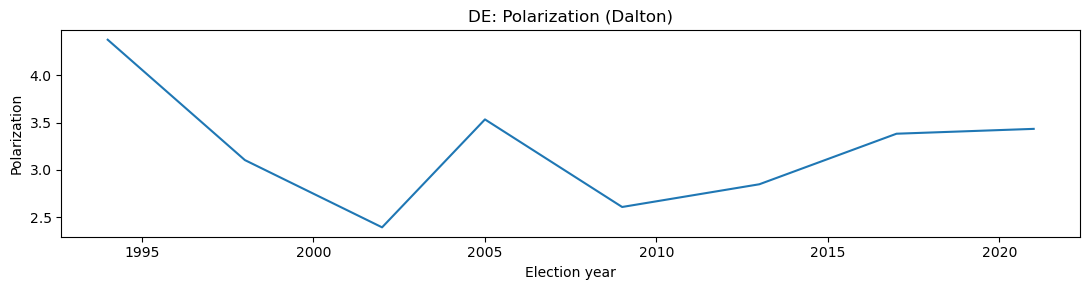


DE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC      down 1998–2017       -4.16      -20.42
                CHR      down 1994–2021       -3.24      -17.34
                NAT        up 2005–2021        3.82       10.30
                LIB        up 1998–2009        2.69        8.32
                LEF      down 2009–2021       -1.59       -6.99
                LEF        up 1998–2009        2.88        6.79
                LIB        up 2013–2021        3.35        6.70
                ECO        up 2013–2021        3.18        6.36
                CHR        up 2005–2013        3.17        6.33
                ECO        up 1994–2009        0.81        3.44
  fragmentation_enp        up 1998–2021        0.54        2.49
polarization_dalton      down 1994–2002       -0.99       -1.98
polarization_dalton        up 2009–2021        0.34        0.83


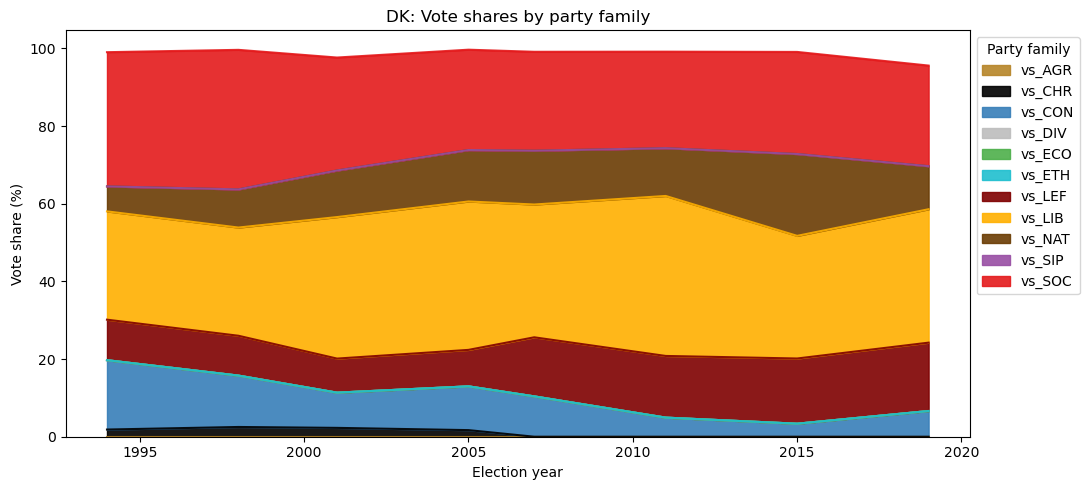

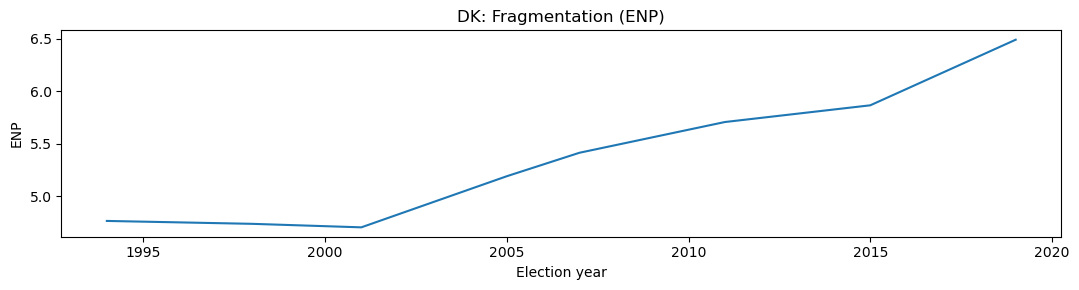

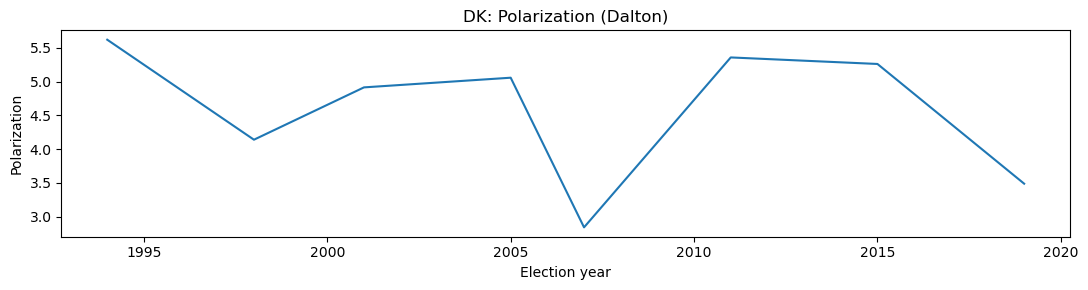


DK — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 1994–2015        2.26       14.64
                CON      down 1994–2015       -3.02      -14.51
                LIB        up 1994–2011        3.65       13.31
                SOC      down 1994–2011       -2.52       -9.70
                LEF        up 2001–2019        2.03        8.83
                CHR      down 1998–2011       -0.80       -2.51
                NAT      down 2005–2019       -0.54       -2.16
                LIB      down 2001–2019       -1.95       -2.09
                CON        up 2011–2019        0.85        1.70
                CON        up 2001–2007        0.66        1.32
  fragmentation_enp        up 1998–2019        0.29        1.76
polarization_dalton      down 1994–2007       -0.69       -2.78
polarization_dalton      down 2011–2019       -0.93       -1.87


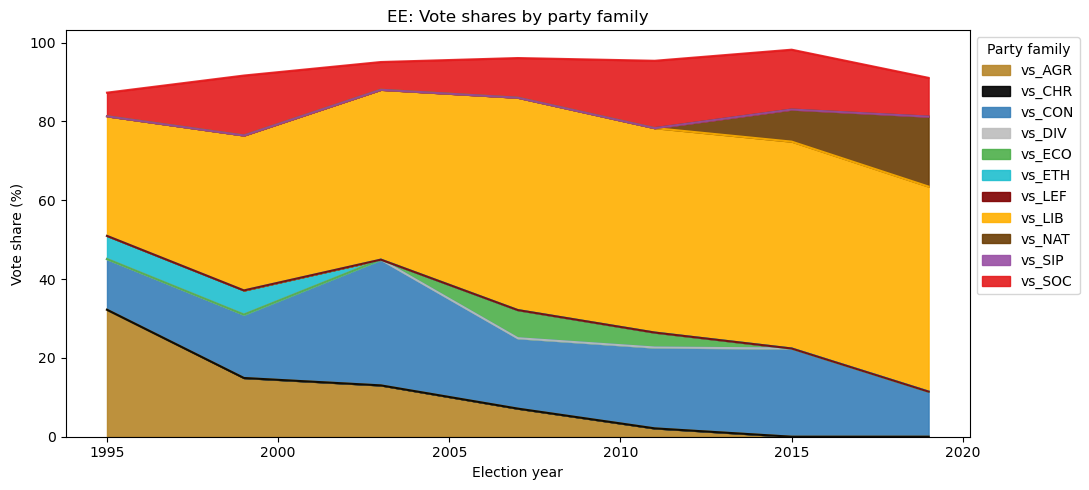

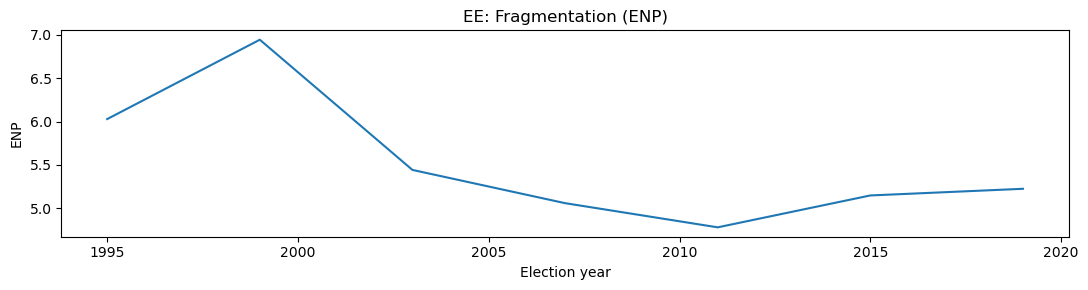

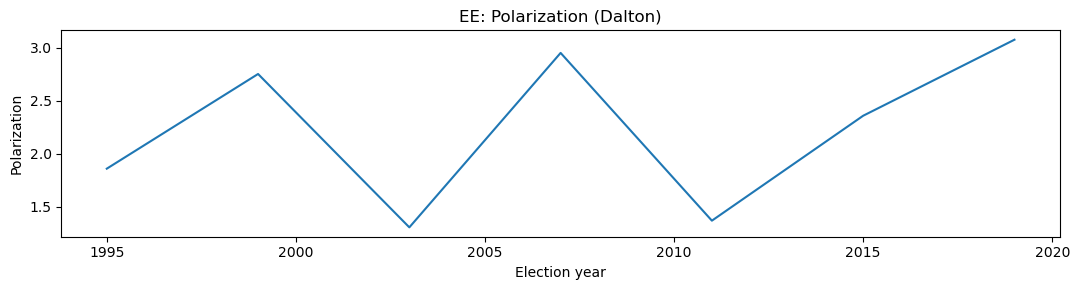


EE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                AGR      down 1995–2019       -4.71      -32.23
                LIB        up 1995–2011        6.01       21.52
                CON      down 2003–2019       -5.12      -20.47
                NAT        up 2007–2019        6.48       17.76
                CON        up 1995–2015        4.23        9.53
                SOC        up 1995–2015        2.71        9.20
                SOC      down 2011–2019       -3.63       -7.26
                ECO      down 2007–2019       -2.73       -7.14
                ETH      down 1995–2007       -3.00       -5.87
                SOC      down 1999–2007       -2.57       -5.14
  fragmentation_enp      down 1995–2011       -0.52       -1.25
  fragmentation_enp        up 2011–2019        0.22        0.44
polarization_dalton        up 2011–2019        0.85        1.71
polarization_dalton      down 2007–2015       -0.30       -0.59


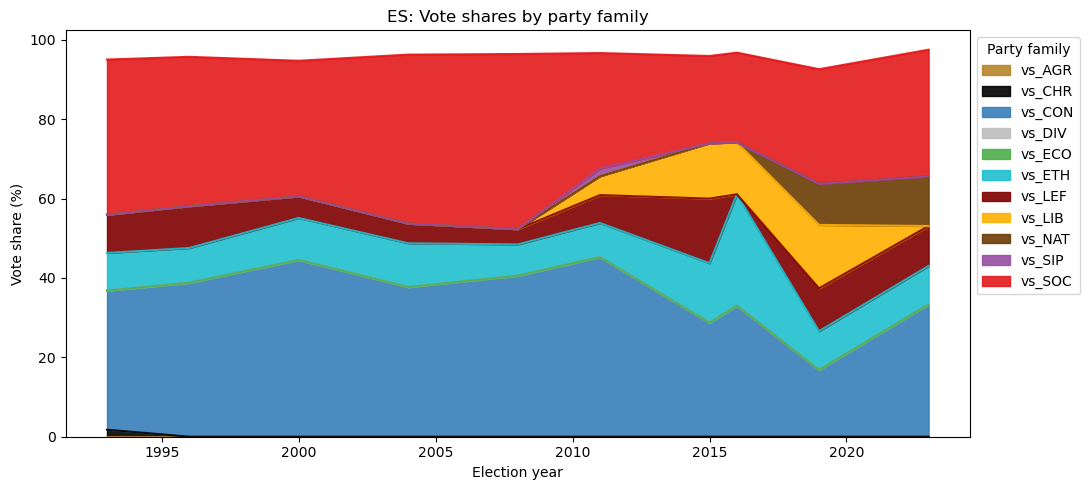

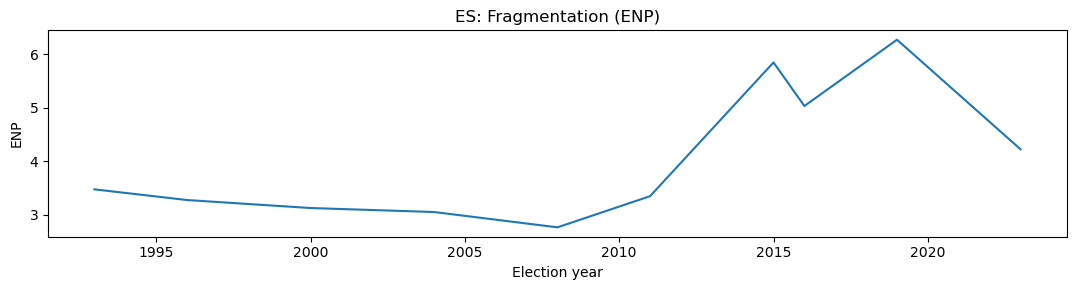

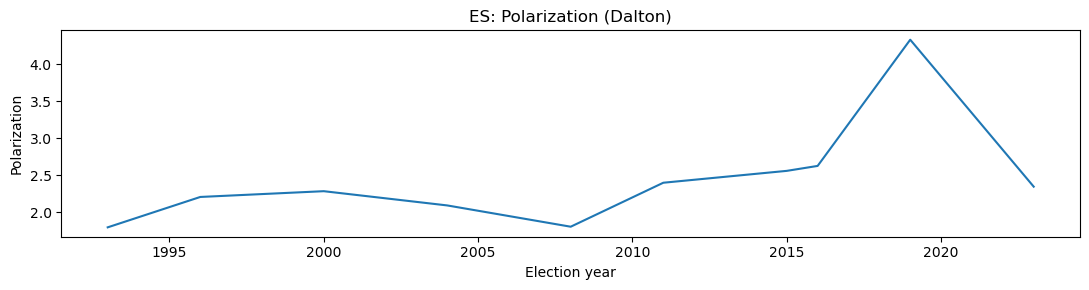


ES — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON      down 1996–2019       -4.10      -21.96
                ETH        up 2008–2016        6.65       20.19
                SOC      down 2004–2016       -7.02      -19.95
                LIB        up 2004–2019        3.63       15.98
                LIB      down 2016–2023       -6.53      -13.06
                NAT        up 2015–2023        5.71       12.48
                LEF        up 2004–2015        3.62       11.32
                LEF        up 2016–2023        5.02       10.04
                SOC        up 2015–2023        4.05        9.95
                CON        up 1993–2000        4.74        9.48
  fragmentation_enp        up 2008–2019        0.87        3.51
  fragmentation_enp      down 2016–2023       -0.40       -0.81
polarization_dalton        up 2004–2019        0.47        2.24
polarization_dalton        up 1993–2000        0.24        0.49


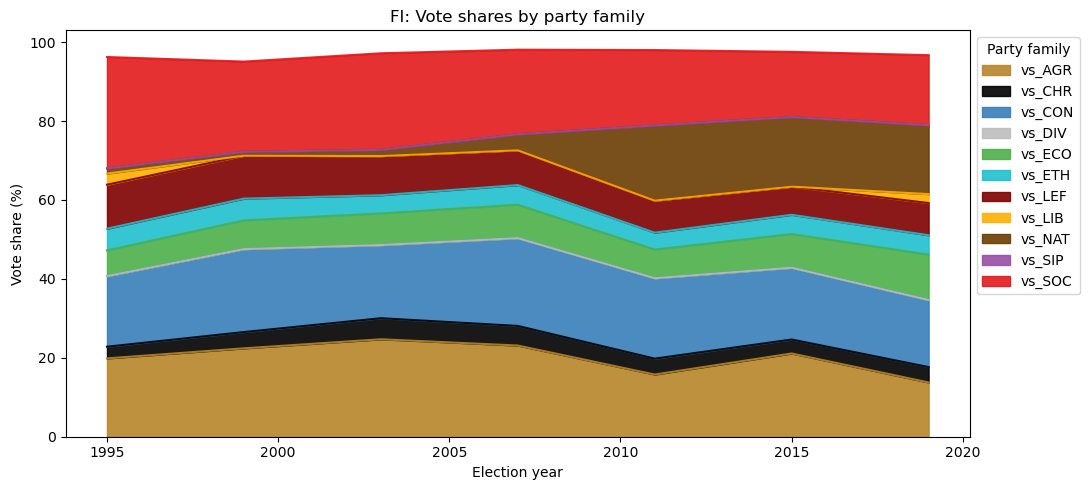

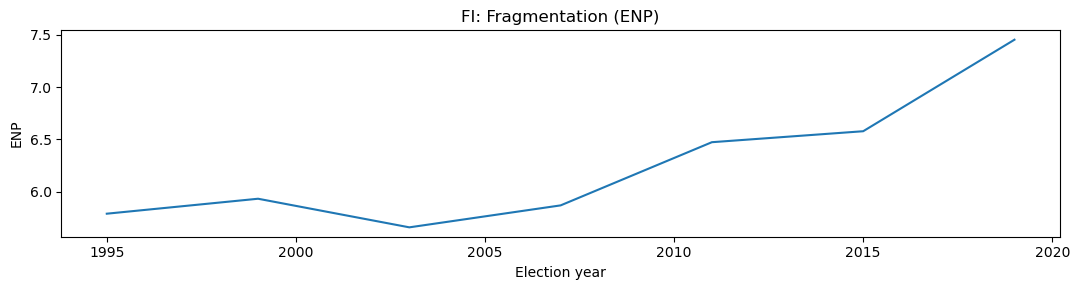

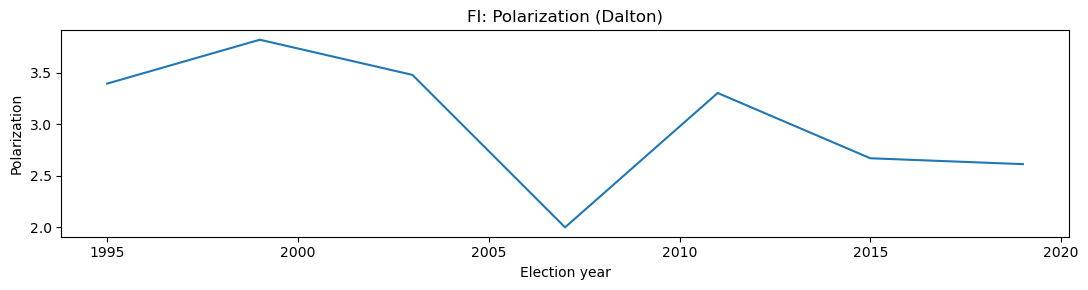


FI — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 1999–2015        5.69       16.66
                AGR      down 2003–2019       -2.16      -10.94
                SOC      down 1995–2019       -1.69      -10.52
                CON      down 2007–2019       -1.86       -5.26
                AGR        up 1995–2003        2.42        4.84
                ECO        up 2011–2019        2.12        4.24
                LEF      down 1995–2015       -0.85       -4.03
                LIB      down 1995–2003       -1.40       -2.81
                LIB        up 2011–2019        1.13        2.25
                CHR        up 1995–2007        0.81        2.01
  fragmentation_enp        up 2003–2019        0.42        1.80
polarization_dalton      down 1999–2007       -0.91       -1.82
polarization_dalton      down 2011–2019       -0.35       -0.69


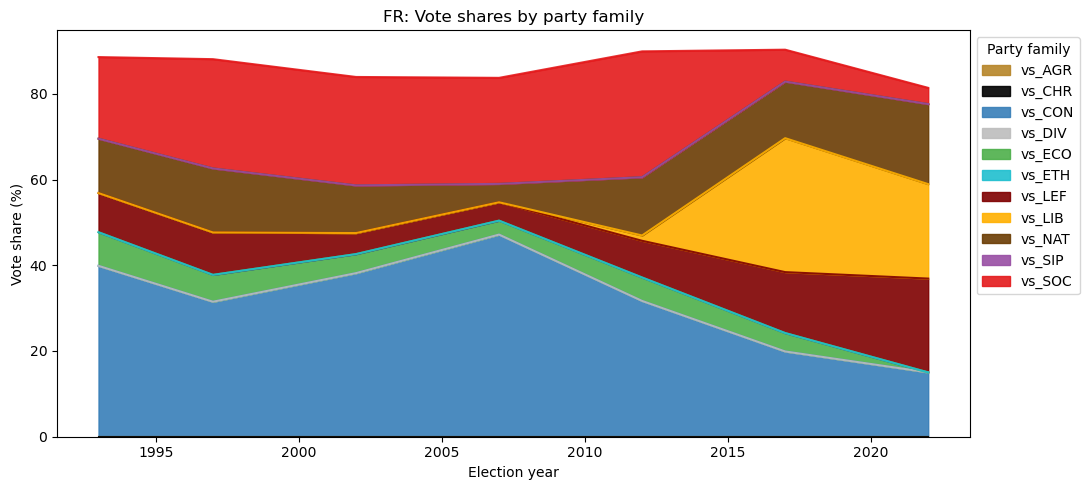

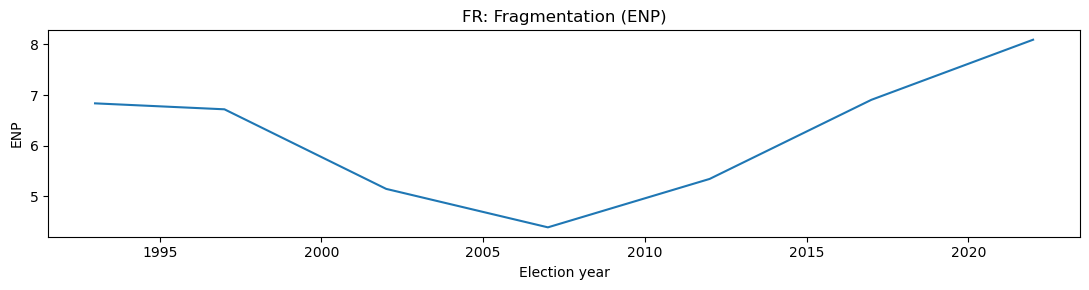

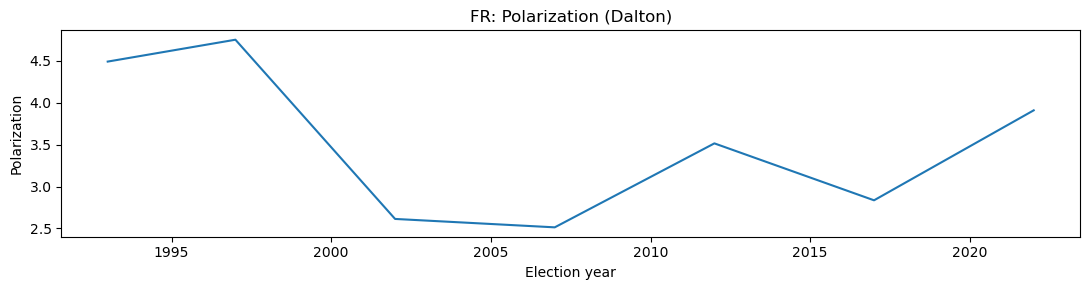


FR — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON      down 1993–2022       -6.51      -24.85
                LIB        up 2002–2022        8.88       22.03
                SOC      down 2007–2022      -10.72      -20.95
                LEF        up 2002–2022        4.48       16.97
                CON        up 1997–2007        7.83       15.66
                SOC        up 1993–2012        2.58       10.31
                NAT      down 1993–2007       -3.05       -8.39
                NAT        up 2002–2022        2.75        7.56
                ECO      down 2012–2022       -2.73       -5.46
                LEF      down 1993–2007       -2.46       -4.85
  fragmentation_enp        up 2007–2022        1.32        3.71
  fragmentation_enp      down 1993–2007       -1.01       -2.45
polarization_dalton      down 1993–2007       -1.03       -1.97
polarization_dalton        up 2002–2022        0.27        1.29


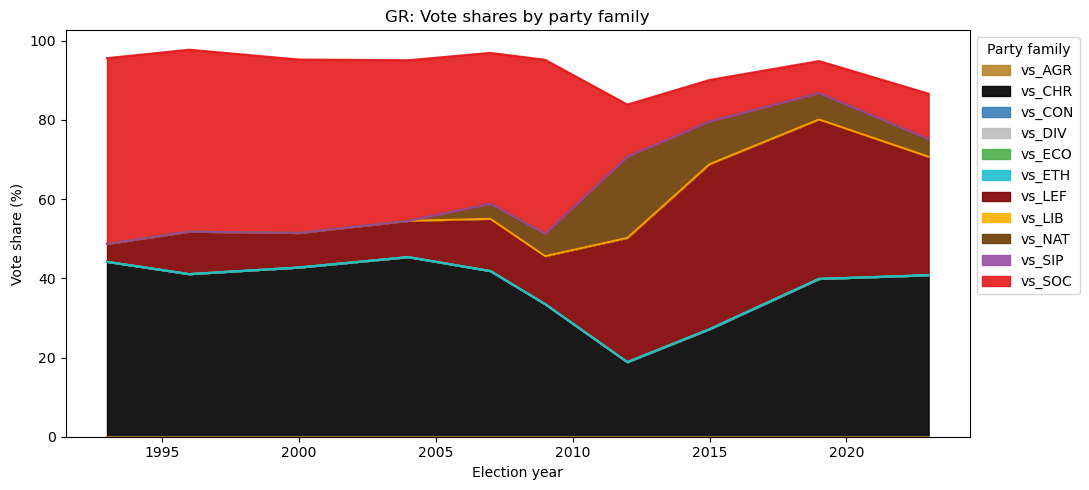

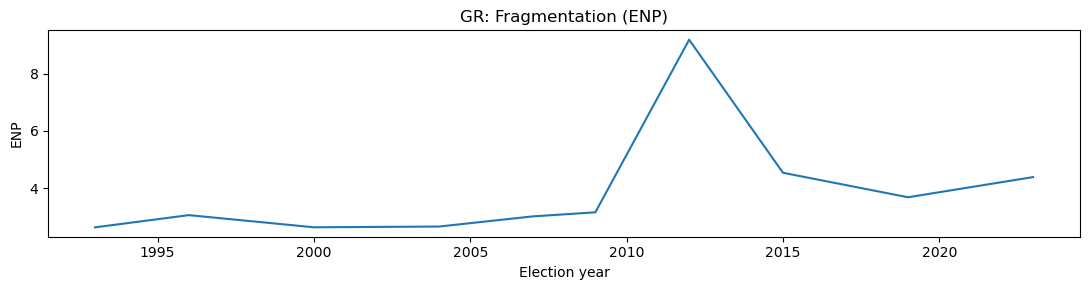

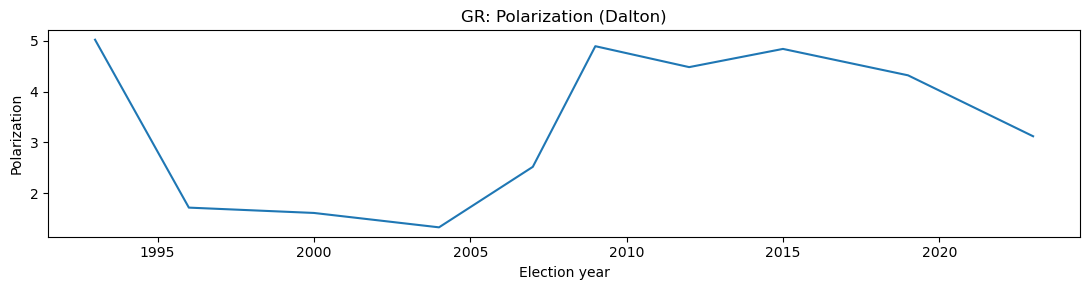


GR — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC      down 1993–2019       -6.47      -38.78
                LEF        up 1993–2019        5.69       35.73
                CHR        up 2012–2023        8.66       21.94
                CHR      down 1993–2015       -4.35      -17.02
                NAT      down 2012–2023       -5.04      -16.03
                LEF      down 2015–2023       -5.88      -11.76
                NAT        up 2000–2015        3.91       10.77
                CHR        up 1996–2004        2.15        4.29
                SOC        up 2004–2009        1.69        3.38
                LEF      down 1996–2004       -0.79       -1.57
  fragmentation_enp      down 2012–2019       -2.75       -5.49
  fragmentation_enp        up 2000–2015        1.05        1.90
polarization_dalton      down 1993–2004       -0.95       -3.69
polarization_dalton        up 2000–2012        1.07        2.87


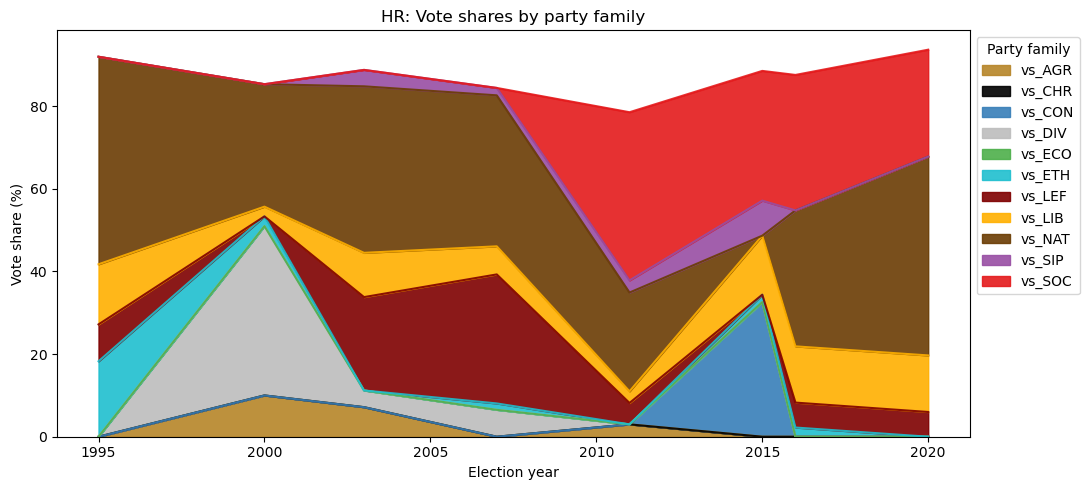

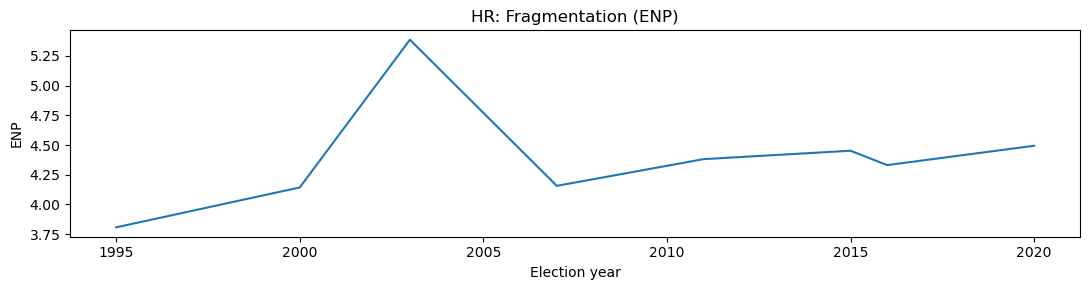

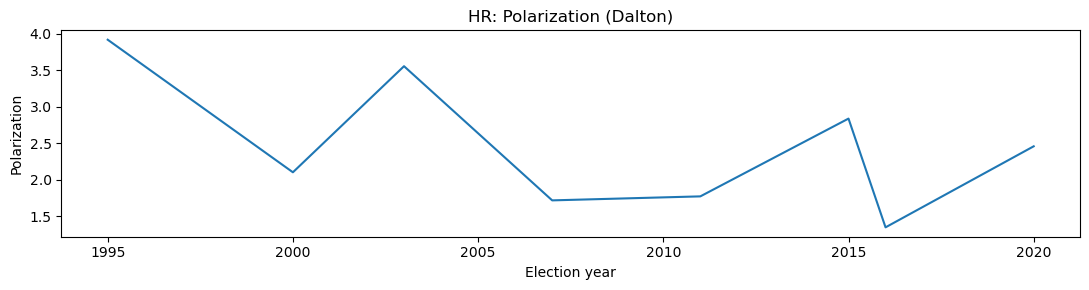


HR — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT      down 1995–2015      -10.48      -50.24
                DIV      down 2000–2015       -7.51      -40.99
                CON      down 2015–2020      -16.30      -32.59
                CON        up 2007–2015       16.30       32.59
                SOC        up 2003–2015       18.03       31.40
                NAT        up 2011–2020       14.28       24.22
                LEF      down 2003–2015      -12.16      -22.60
                LEF        up 1995–2007       11.23       22.30
                ETH      down 1995–2007       -4.77      -16.72
                SOC      down 2011–2020       -3.36      -14.85
  fragmentation_enp        up 1995–2003        0.79        1.58
  fragmentation_enp      down 2003–2011       -0.50       -1.01
polarization_dalton      down 1995–2020       -0.33       -1.46
polarization_dalton        up 2007–2015        0.56        1.12


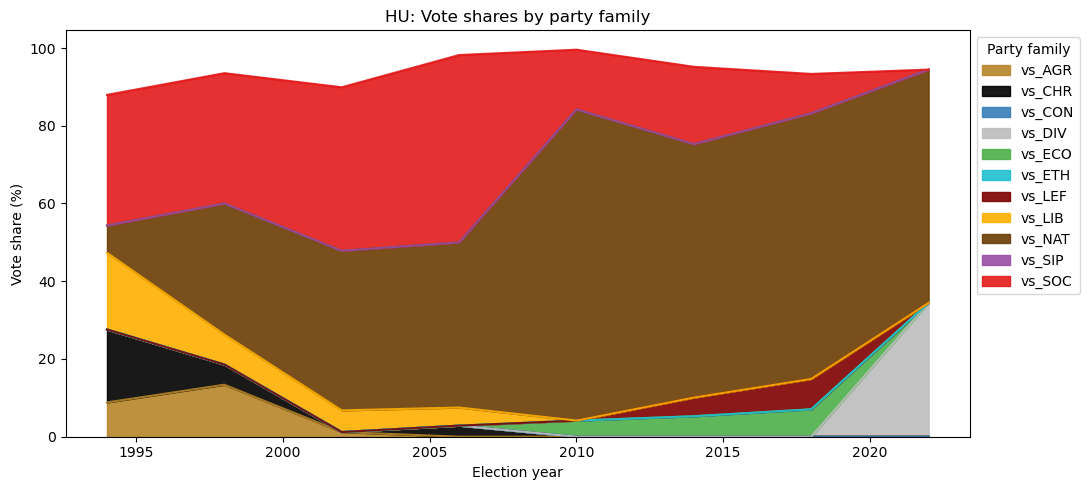

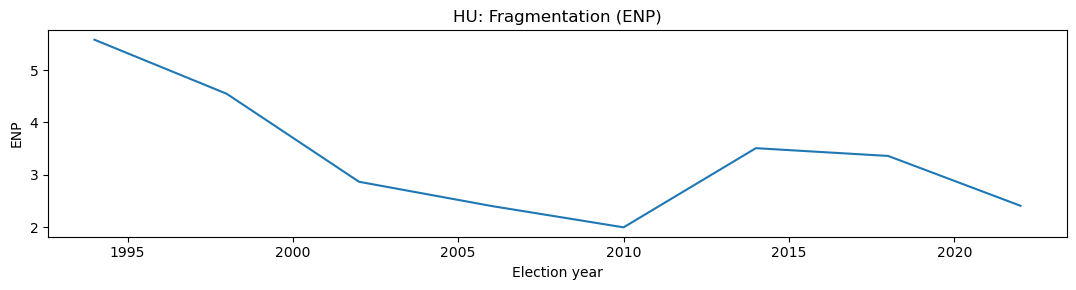

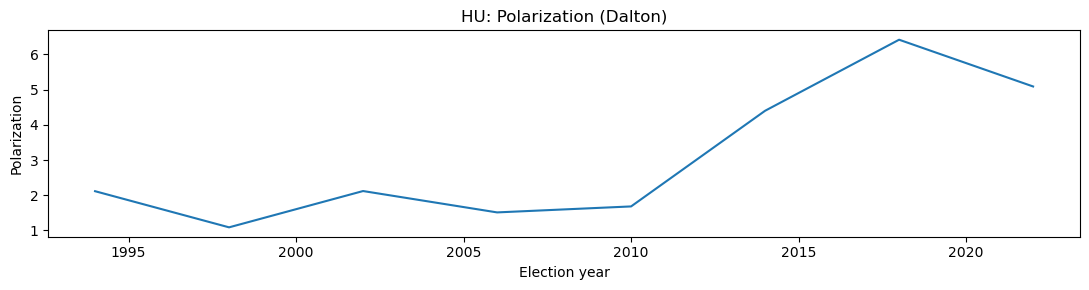


HU — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 1994–2014       13.06       58.19
                SOC      down 2002–2022      -10.01      -42.05
                DIV        up 2014–2022       17.22       34.44
                NAT      down 2010–2022       -4.23      -20.05
                LIB      down 1994–2014       -3.43      -19.74
                CHR      down 1994–2014       -3.99      -18.76
                SOC        up 1994–2006        5.79       14.60
                AGR      down 1994–2010       -3.70       -8.82
                LEF        up 2006–2018        3.15        7.82
                ECO        up 2002–2018        2.05        7.06
  fragmentation_enp      down 1994–2010       -0.95       -3.58
  fragmentation_enp      down 2014–2022       -0.55       -1.10
polarization_dalton        up 1998–2022        1.09        4.00
polarization_dalton      down 2002–2010       -0.22       -0.44


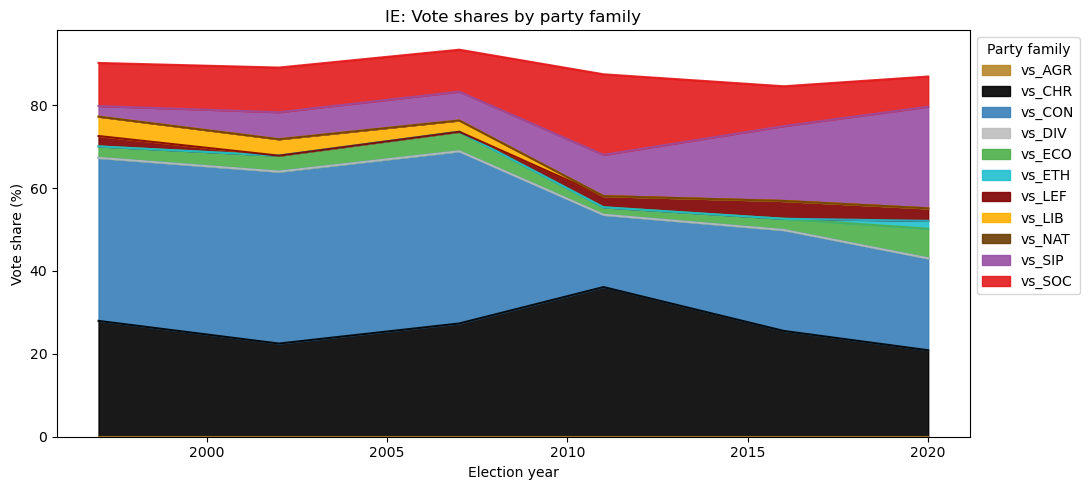

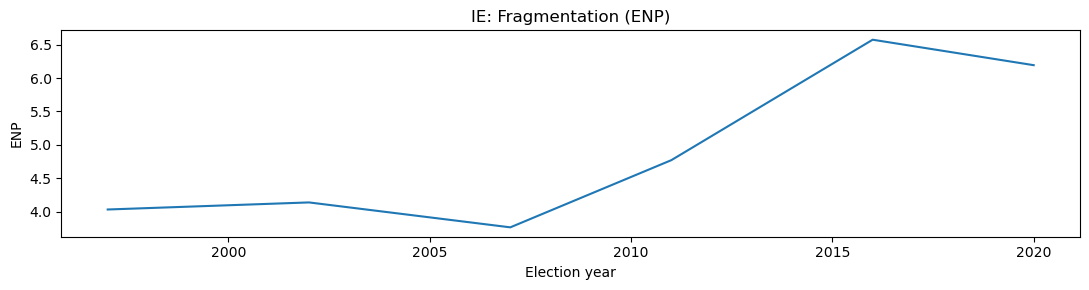

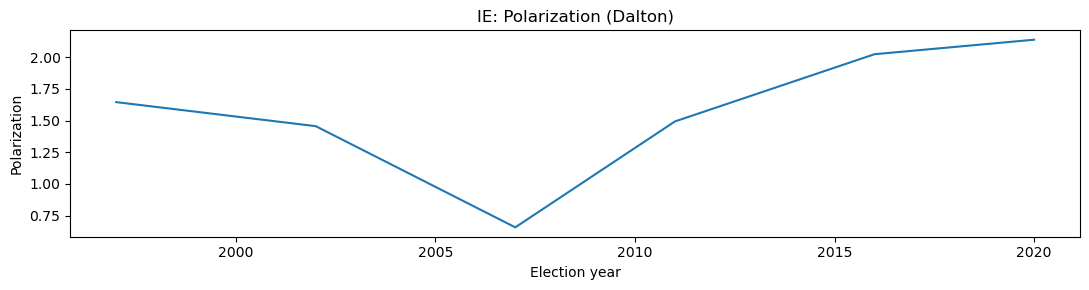


IE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SIP        up 1997–2020        4.19       21.98
                CON      down 2002–2016      -10.31      -17.13
                CHR        up 2002–2011        6.81       13.63
                SOC      down 2011–2020       -6.08      -12.17
                SOC        up 2002–2011        4.34        8.67
                CHR      down 2007–2020       -4.26       -6.46
                ECO        up 2011–2020        2.67        5.33
                CON        up 2011–2020        2.37        4.73
                LIB      down 1997–2016       -1.44       -4.68
                LEF        up 2002–2016        1.75        4.30
  fragmentation_enp        up 2002–2020        0.81        2.05
polarization_dalton        up 2007–2020        0.50        1.48
polarization_dalton      down 1997–2007       -0.49       -0.99


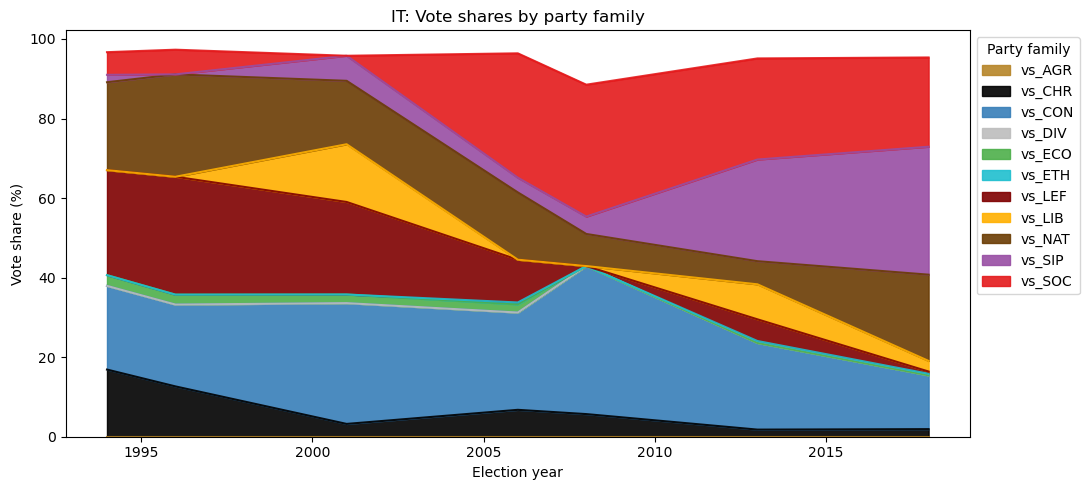

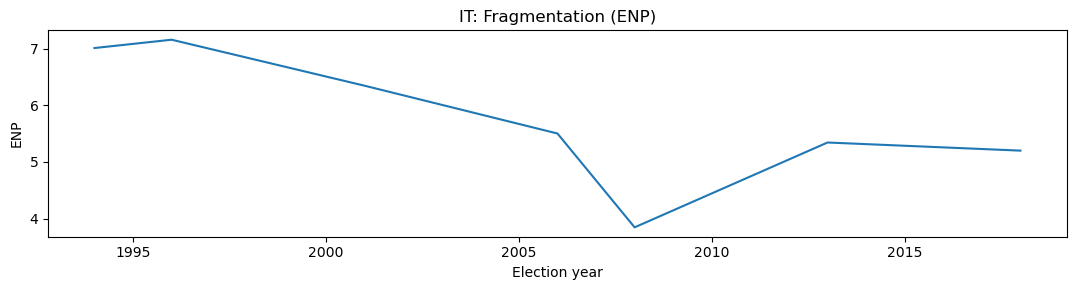

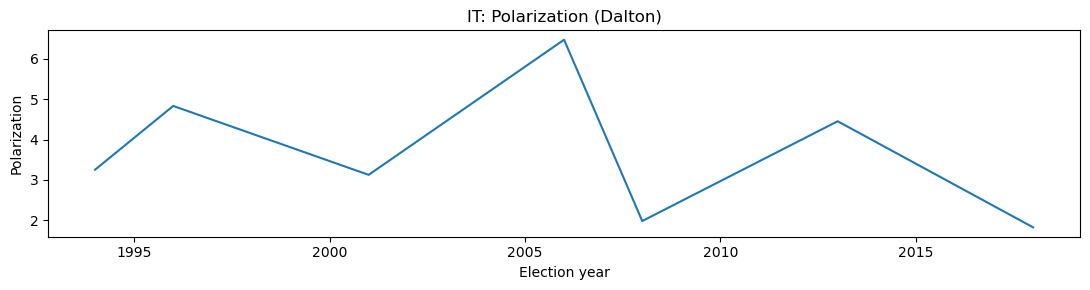


IT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SIP        up 1994–2018        7.22       30.30
                SOC        up 1996–2008       14.56       26.96
                LEF      down 1994–2013       -6.32      -20.95
                NAT      down 1994–2013       -4.24      -16.28
                CON        up 1994–2008        3.34       16.18
                CHR      down 1994–2018       -3.54      -14.97
                LIB      down 2001–2008       -7.26      -14.51
                LIB        up 1994–2001        7.26       14.51
                NAT        up 2008–2018        6.81       13.62
                CON      down 2006–2018       -6.59      -10.93
  fragmentation_enp      down 1994–2008       -0.80       -3.17
  fragmentation_enp        up 2008–2018        0.68        1.36
polarization_dalton        up 1996–2006        0.82        1.64
polarization_dalton      down 2001–2013       -0.79        1.33


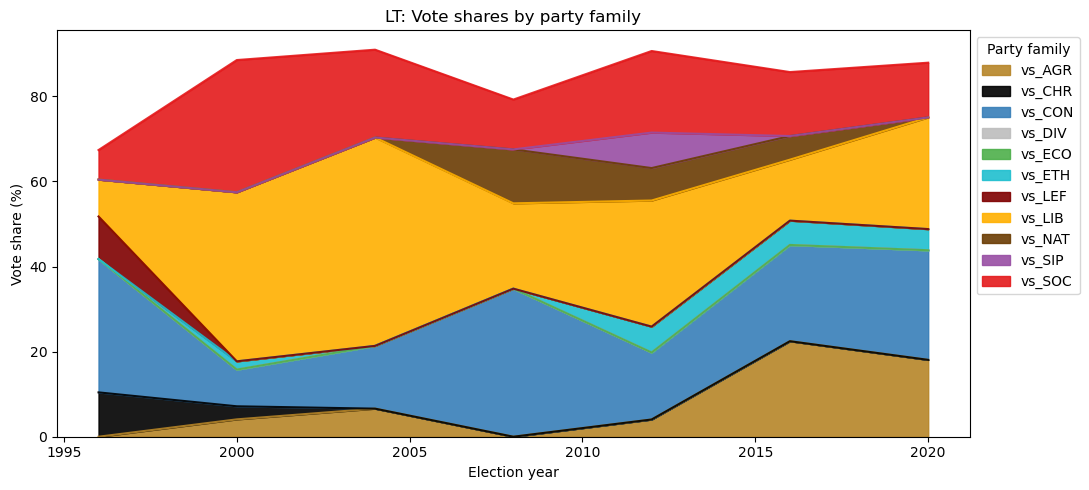

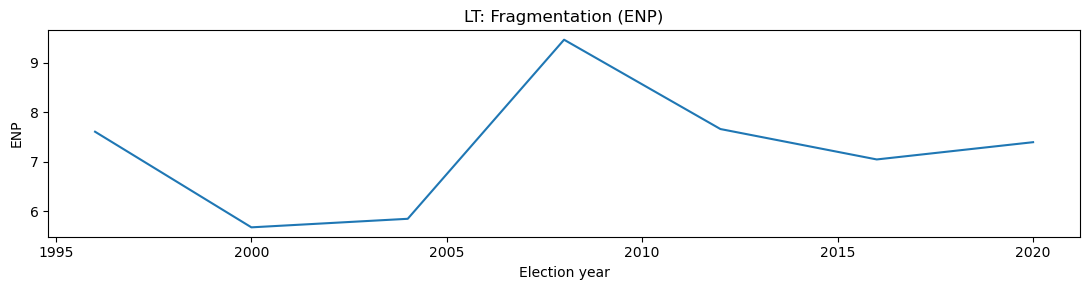

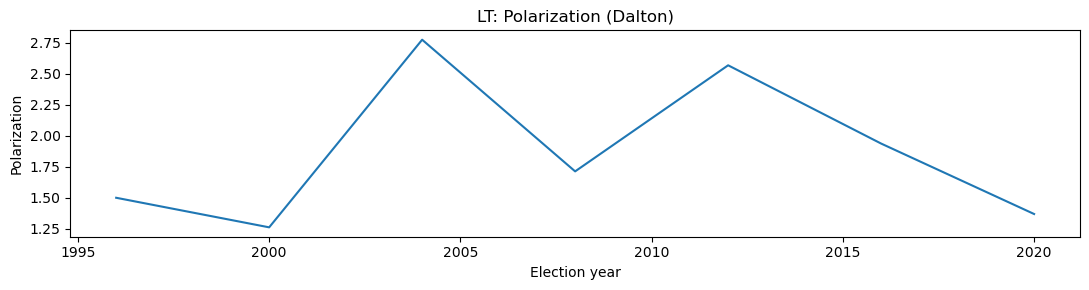


LT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB        up 1996–2004       20.16       40.31
                SOC      down 2000–2020       -4.52      -18.22
                AGR        up 2008–2020        9.12       18.07
                CON        up 2000–2020        6.20       17.15
                CON      down 1996–2004       -8.29      -16.59
                SOC        up 1996–2004        6.85       13.70
                LIB      down 2000–2020       -6.02      -13.49
                NAT      down 2008–2020       -3.69      -12.68
                CON      down 2008–2016       -6.09      -12.18
                CHR      down 1996–2008       -3.38      -10.43
  fragmentation_enp      down 2008–2016       -1.21       -2.42
  fragmentation_enp        up 2000–2012        1.40        1.98
polarization_dalton      down 2012–2020       -0.60       -1.20
polarization_dalton        up 1996–2008        0.43        0.21


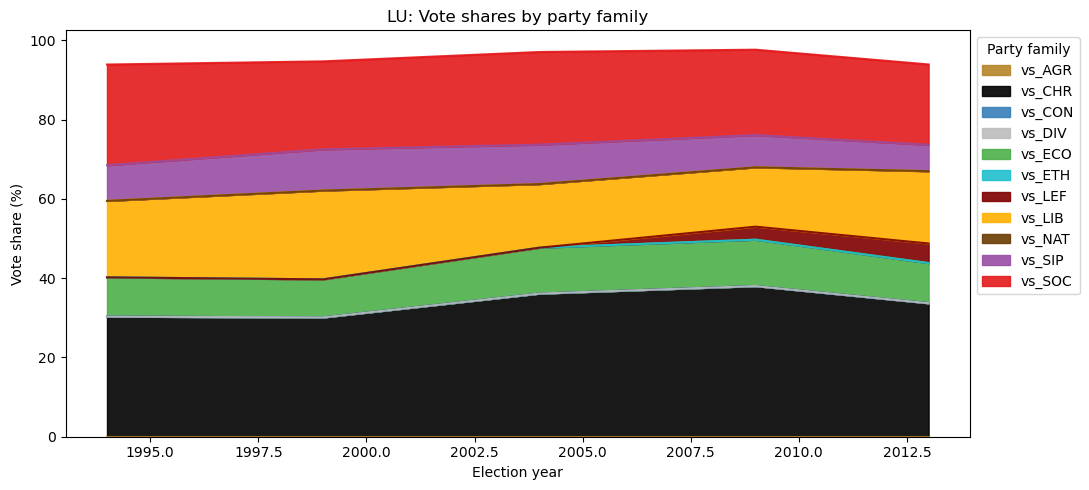

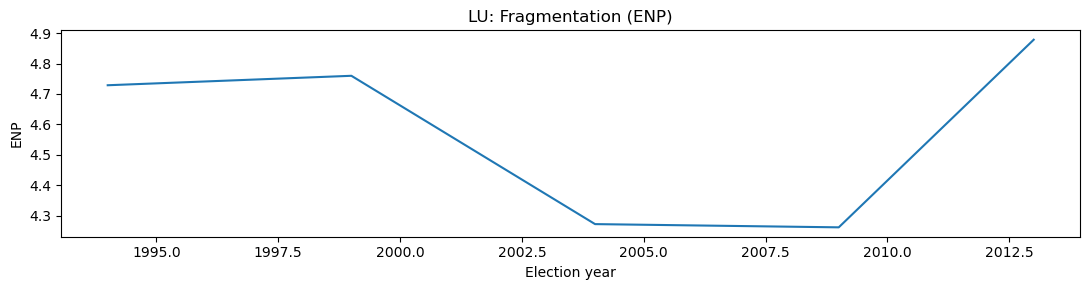

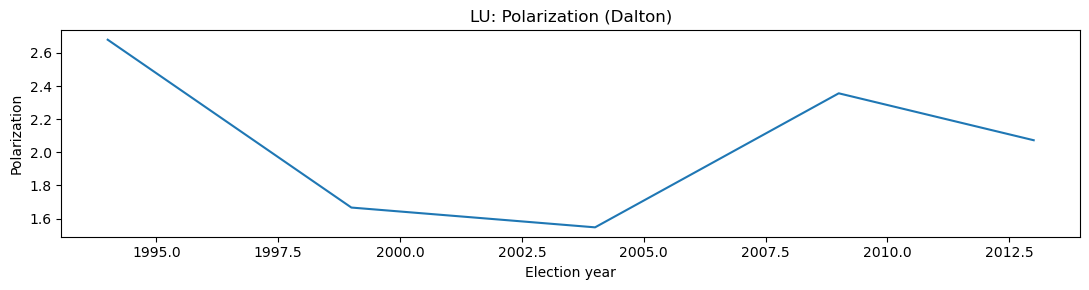


LU — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CHR        up 1994–2009        3.43        7.71
                SOC      down 1994–2013       -1.28       -5.12
                LEF        up 1999–2013        2.06        4.94
                LIB      down 1994–2009       -2.67       -4.33
                SIP      down 1999–2013       -1.39       -3.76
                CHR      down 2004–2013       -1.22       -2.43
                LIB        up 2004–2013        1.10        2.20
                ECO        up 1994–2009        0.95        1.80
                ECO      down 2004–2013       -0.72       -1.45
                SIP        up 1994–2004        0.47        0.95
  fragmentation_enp        up 2004–2013        0.30        0.61
  fragmentation_enp      down 1994–2009       -0.24       -0.47
polarization_dalton      down 1994–2004       -0.57       -1.13
polarization_dalton        up 1999–2013        0.30        0.41


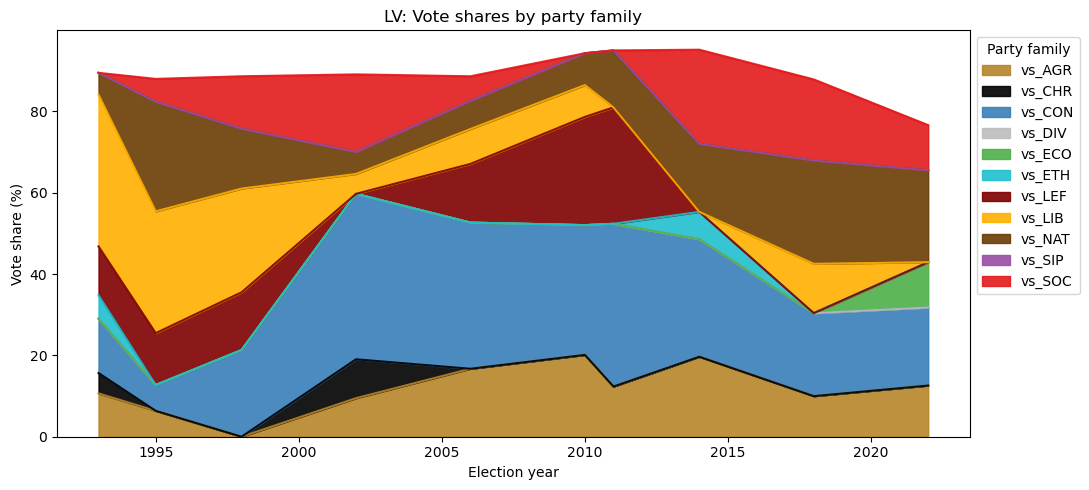

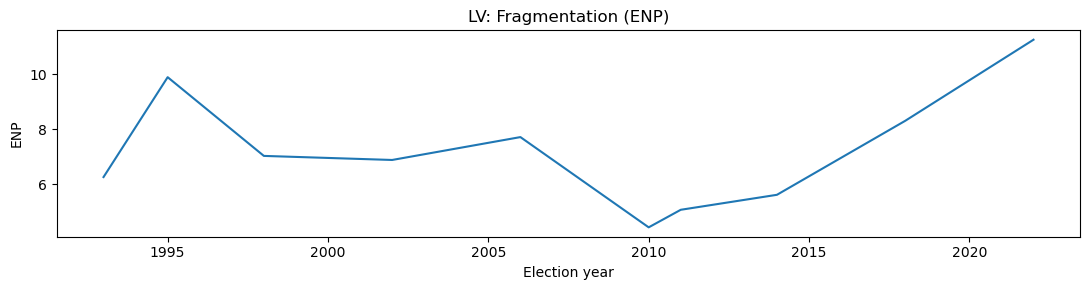

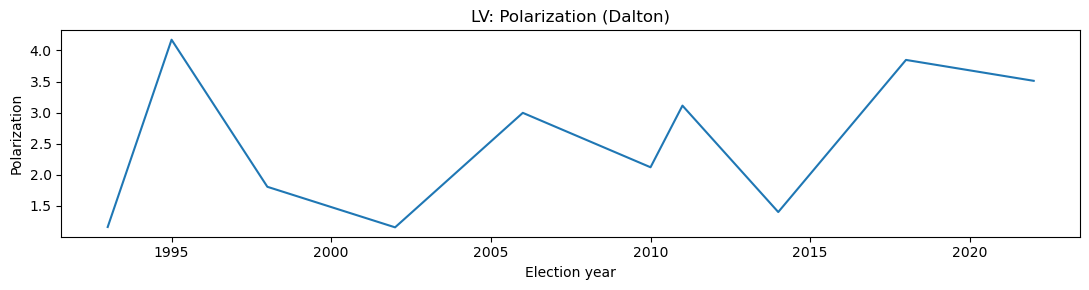


LV — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB      down 1993–2014       -7.02      -37.31
                LEF        up 2002–2011       10.20       28.62
                CON        up 1993–2011        7.62       26.66
                LEF      down 2010–2018      -13.81      -26.61
                CON      down 2002–2022       -5.13      -21.47
                NAT      down 1995–2006       -7.34      -20.02
                SOC        up 2010–2018       10.77       19.92
                SOC        up 1993–2002        6.59       19.10
                NAT        up 2002–2022        3.57       17.20
                AGR        up 1995–2010        5.08       13.75
  fragmentation_enp        up 2010–2022        1.67        6.81
  fragmentation_enp      down 1995–2011       -1.35       -4.82
polarization_dalton      down 1995–2002       -1.51       -3.02
polarization_dalton        up 1993–2010        0.47        0.96


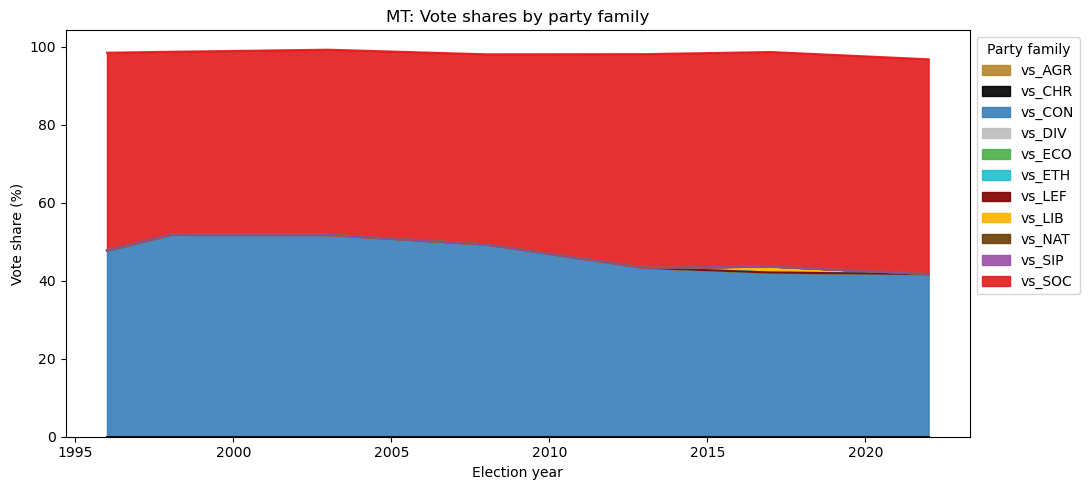

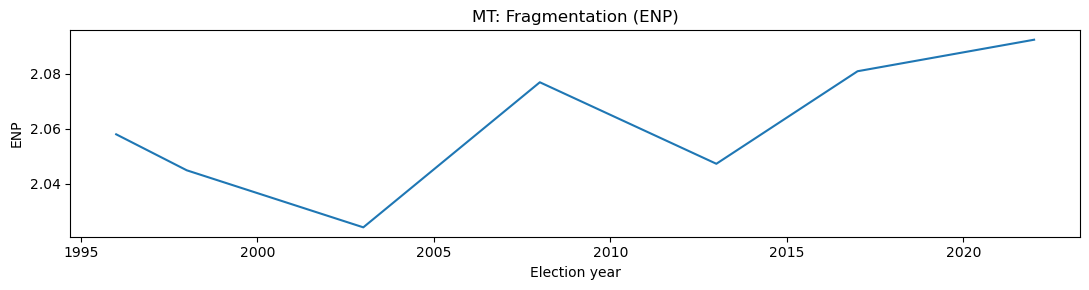

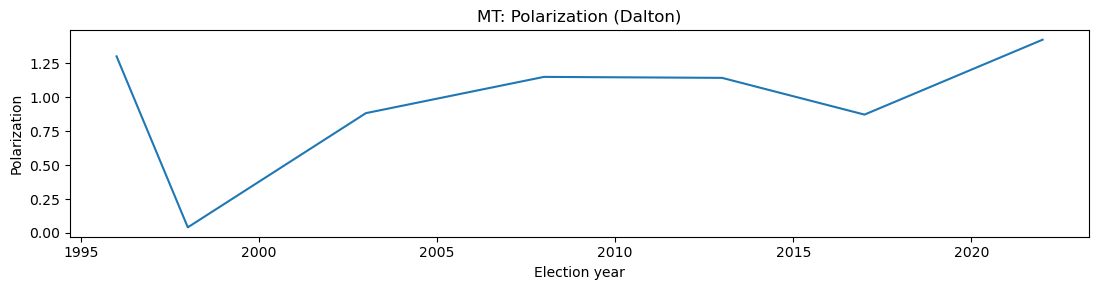


MT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON      down 1998–2022       -2.47      -10.07
                SOC        up 1998–2017        2.56        8.07
                CON        up 1996–2003        1.99        3.99
                SOC      down 1996–2003       -1.61       -3.22
                LIB        up 2008–2017        0.78        1.56
polarization_dalton        up 1998–2008        0.55        1.11
polarization_dalton      down 1996–2003       -0.21       -0.42


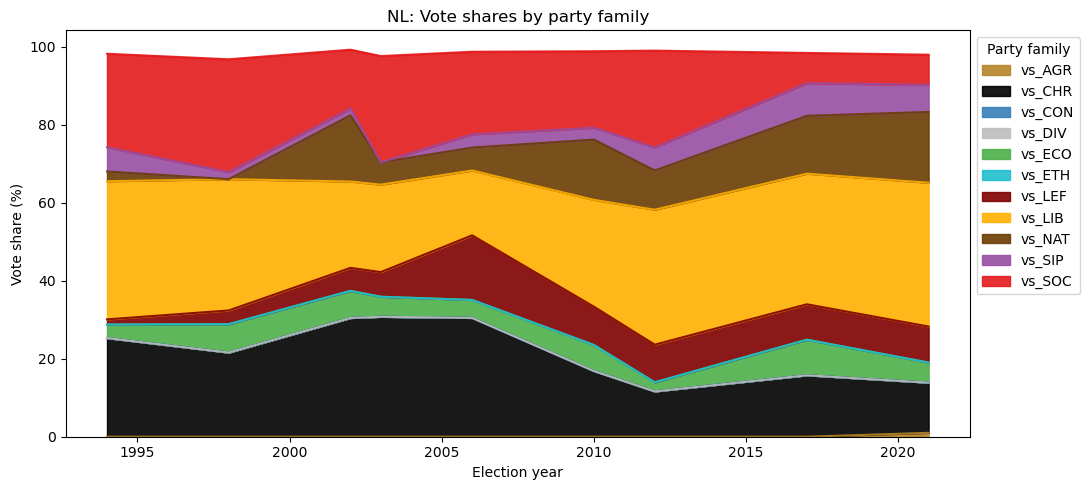

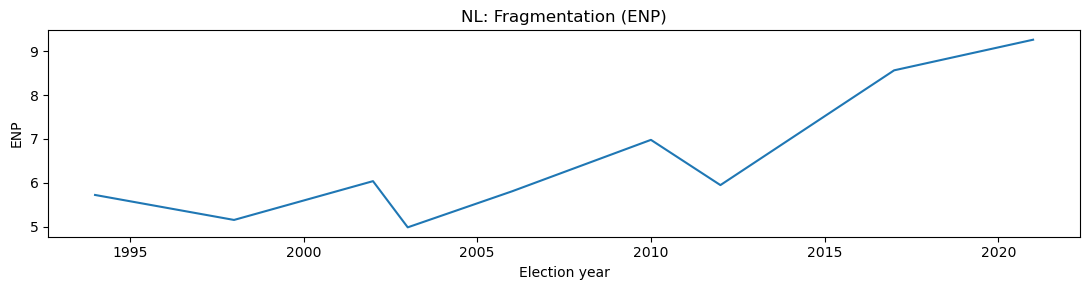

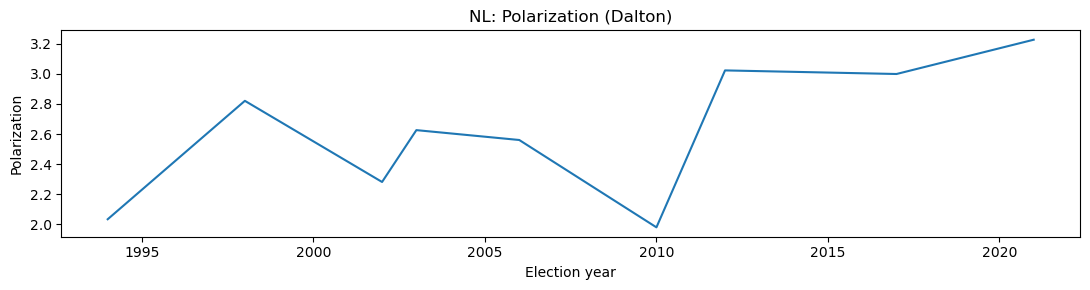


NL — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB      down 1994–2006       -5.01      -18.81
                SOC      down 1994–2021       -4.72      -16.22
                NAT        up 1994–2021        4.22       15.67
                CHR      down 2003–2017       -5.64      -15.01
                LIB        up 2003–2021        3.92       14.46
                NAT      down 2002–2006       -5.56      -11.11
                SOC        up 2002–2012        2.43        9.73
                LEF        up 1994–2010        2.69        8.51
                LEF      down 2006–2012       -3.46       -6.92
                SIP      down 1994–2003       -1.57       -6.23
  fragmentation_enp        up 2003–2021        1.15        4.28
  fragmentation_enp        up 1994–2002        0.16        0.32
polarization_dalton      down 2003–2010       -0.32       -0.64
polarization_dalton        up 2006–2017        0.37        0.44


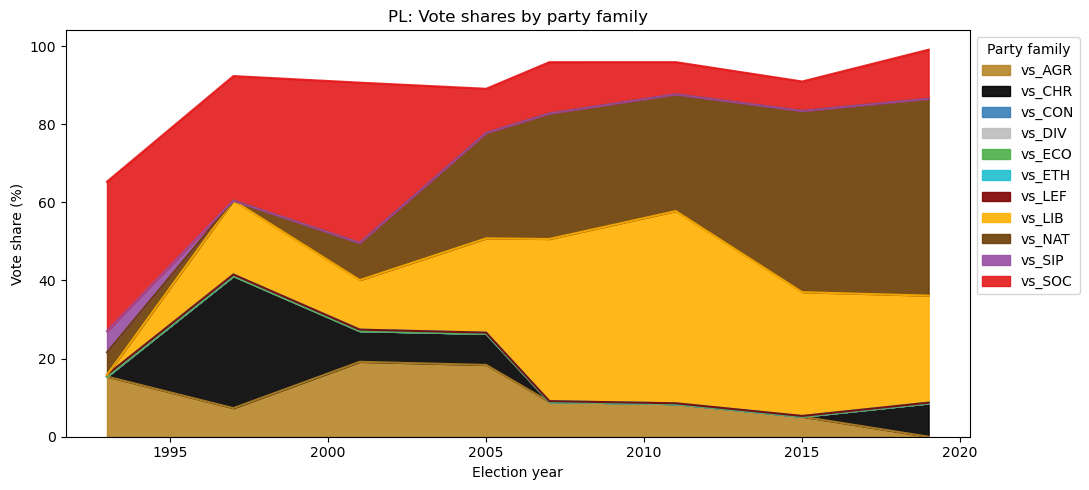

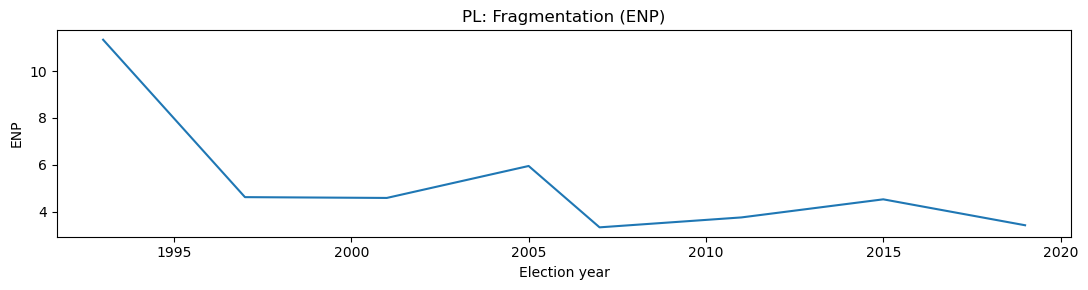

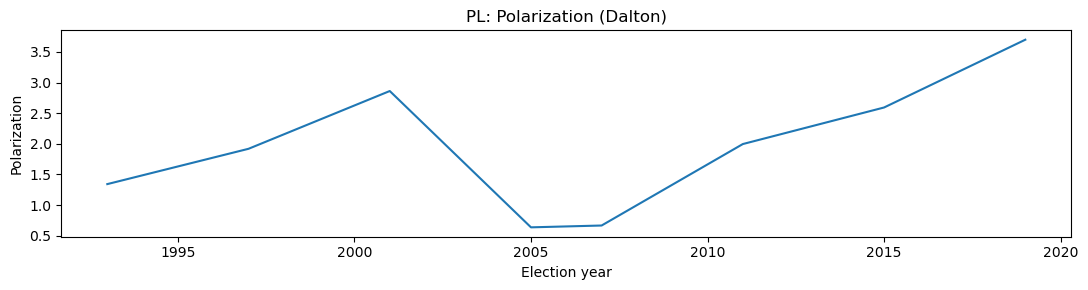


PL — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB        up 1993–2011        8.97       49.20
                NAT        up 1993–2019        7.58       44.63
                CHR      down 1997–2011       -6.95      -33.83
                SOC      down 1997–2015       -7.14      -24.33
                AGR      down 2001–2019       -4.05      -19.18
                LIB      down 2007–2019       -7.91      -14.12
                CHR        up 2011–2019        4.27        8.55
                CHR        up 1993–2001        3.94        7.88
                SIP      down 1993–2001       -2.71       -5.41
                SOC        up 2011–2019        2.16        4.32
  fragmentation_enp      down 1993–2019       -1.32       -7.93
  fragmentation_enp        up 1997–2005        0.67        1.33
polarization_dalton        up 2005–2019        0.83        3.06
polarization_dalton        up 1993–2001        0.76        1.52


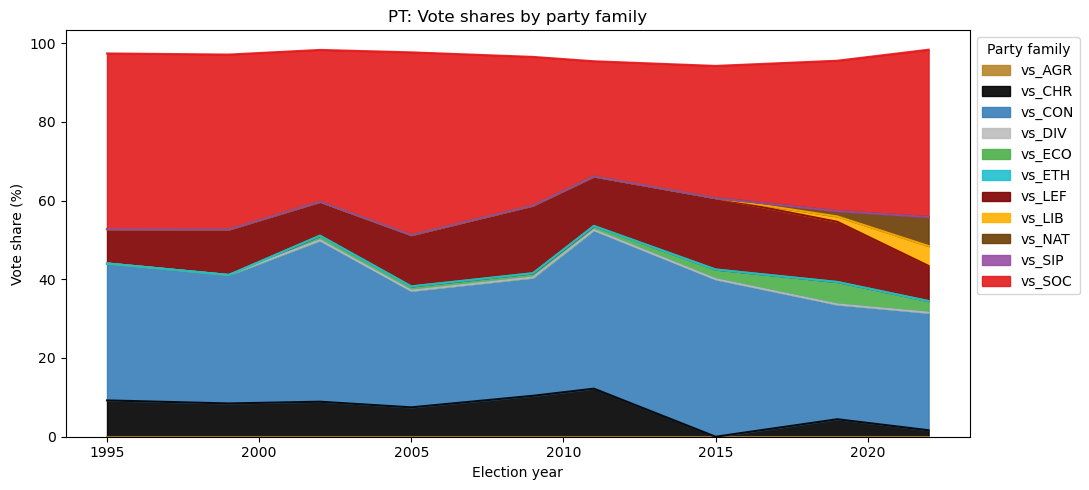

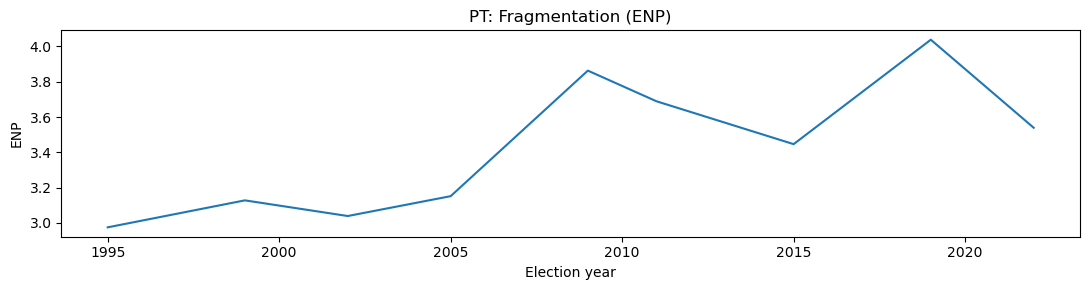

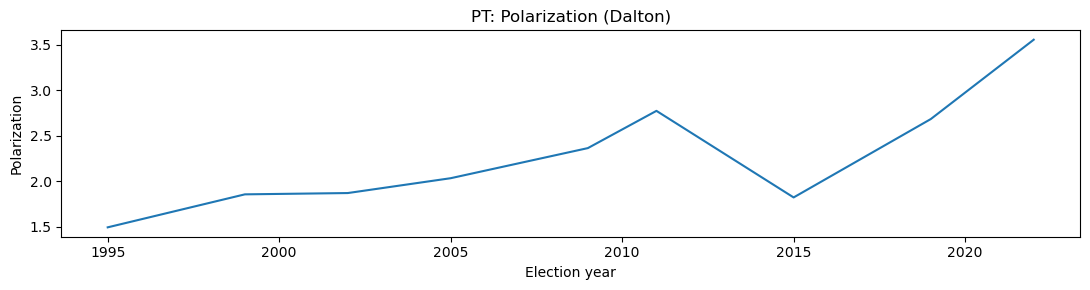


PT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC        up 2011–2022        4.47       13.26
                SOC      down 1995–2015       -3.52      -11.04
                CON      down 2011–2022       -5.32      -10.43
                CON        up 2005–2015        5.16       10.40
                LEF      down 2015–2022       -4.61       -9.21
                NAT        up 2011–2022        2.18        7.38
                CON        up 1995–2002        3.12        6.23
                CHR      down 2009–2019       -4.54       -5.96
                LIB        up 2011–2022        1.60        5.05
                ECO        up 2009–2019        1.51        4.61
  fragmentation_enp        up 2002–2019        0.29        1.00
  fragmentation_enp      down 2009–2015       -0.21       -0.42
polarization_dalton        up 2015–2022        0.87        1.74
polarization_dalton        up 1995–2011        0.27        1.28


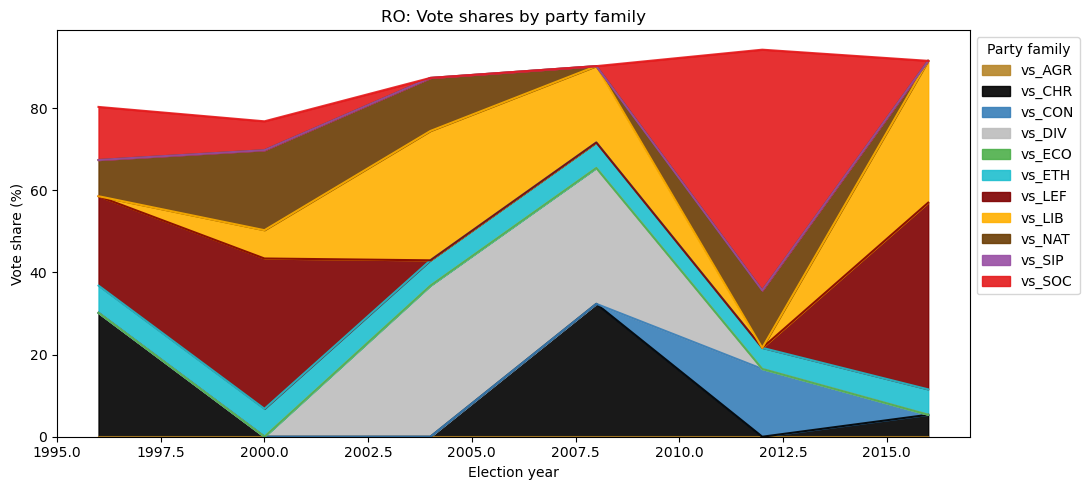

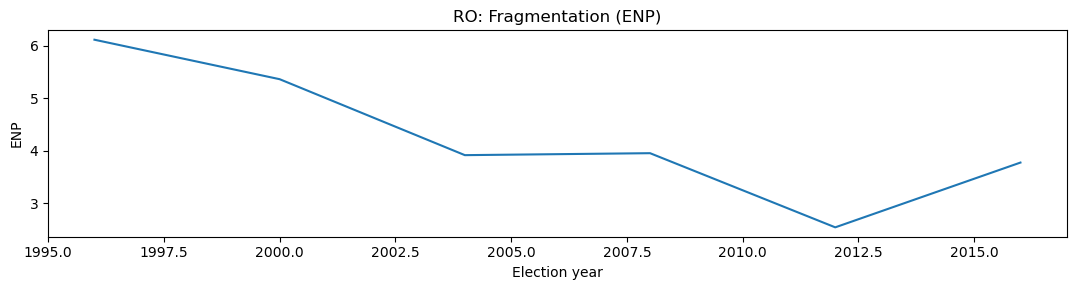

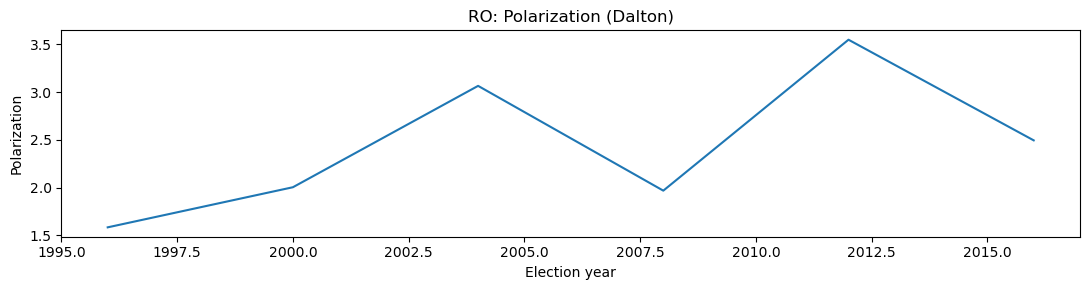


RO — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC        up 2004–2012       29.32       58.63
                LEF        up 2008–2016       22.74       45.48
                DIV      down 2004–2016      -17.47      -36.80
                LIB        up 1996–2016        9.86       34.54
                DIV        up 1996–2008       17.47       33.10
                CHR        up 2000–2008       16.18       32.36
                LIB      down 2004–2012      -15.75      -31.50
                CHR      down 1996–2004      -15.08      -30.17
                CHR      down 2008–2016      -13.51      -27.02
                LEF      down 1996–2008      -14.59      -21.77
  fragmentation_enp      down 1996–2012       -0.83       -3.58
polarization_dalton        up 1996–2016        0.42        0.91


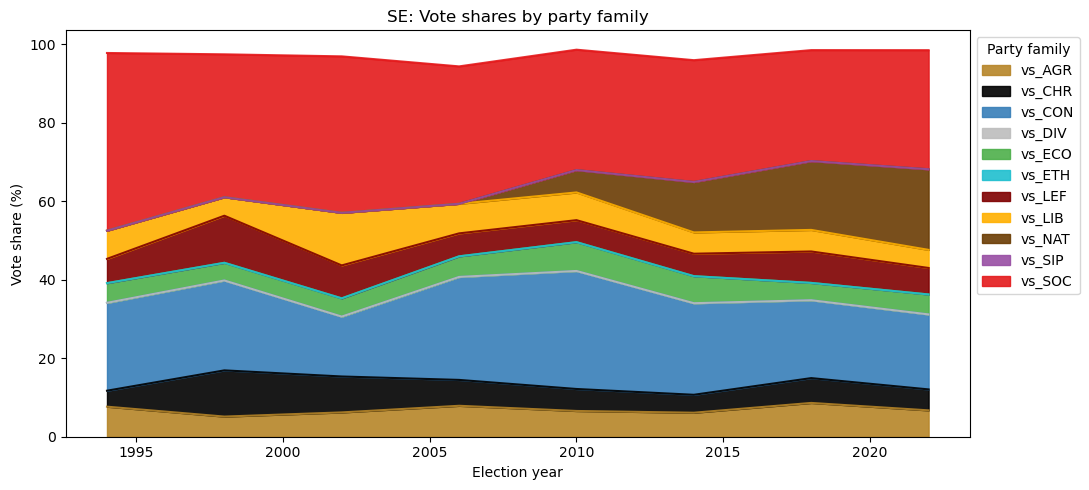

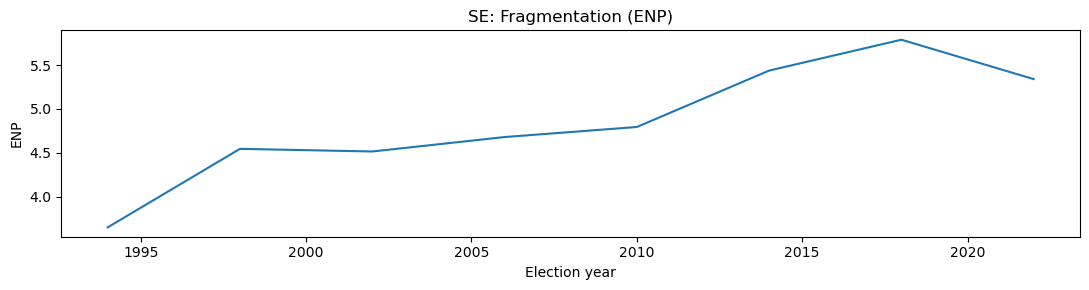

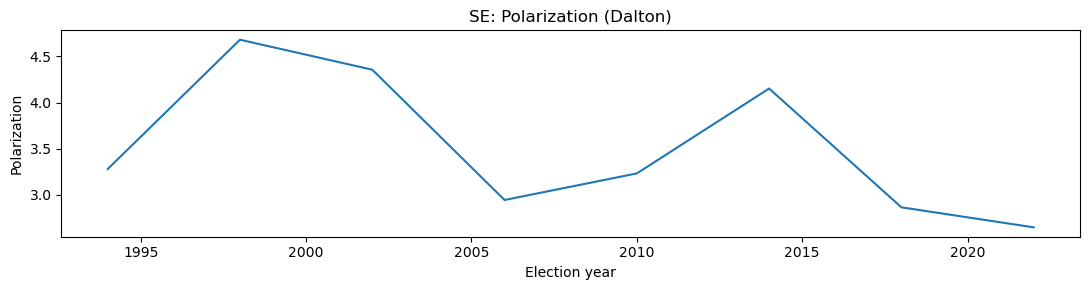


SE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 2002–2022        4.76       20.54
                SOC      down 1994–2018       -2.24      -16.99
                LIB      down 2002–2022       -1.35       -8.79
                CHR      down 1998–2014       -1.79       -7.20
                CON        up 1998–2010        4.53        7.16
                CON      down 2006–2022       -2.89       -7.13
                CON      down 1994–2002       -3.56       -7.12
                LEF      down 1998–2010       -2.23       -6.39
                CHR        up 1994–2002        2.54        5.08
                AGR        up 1998–2006        1.37        2.75
  fragmentation_enp        up 2006–2018        0.44        1.11
  fragmentation_enp        up 1994–2002        0.43        0.86
polarization_dalton      down 1998–2022       -0.59       -2.03
polarization_dalton        up 2006–2014        0.60        1.21


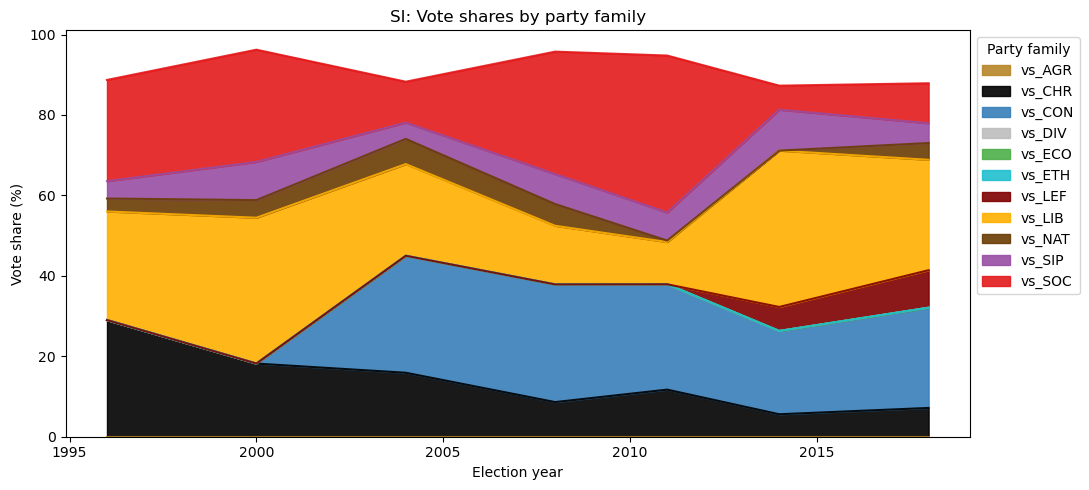

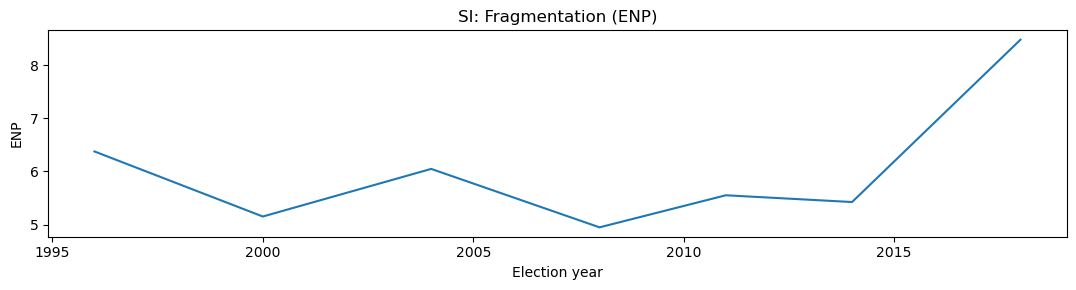

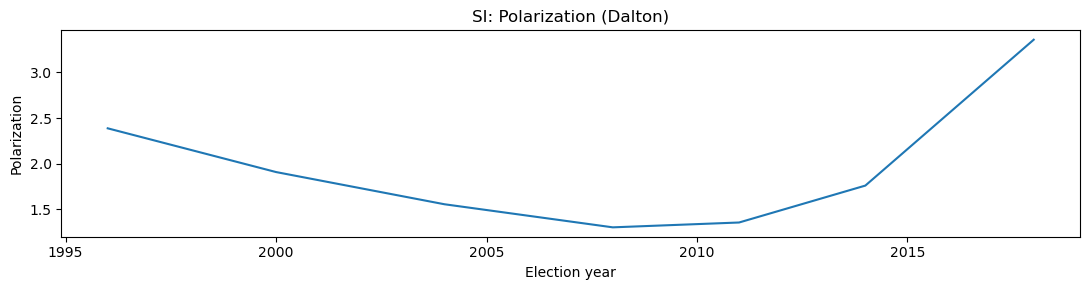


SI — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON        up 1996–2008       14.58       29.26
                CHR      down 1996–2018       -3.44      -21.84
                SOC      down 2008–2018      -13.39      -20.52
                LIB      down 1996–2011       -6.36      -16.51
                SOC      down 1996–2004       -7.50      -15.00
                LIB        up 2008–2018       10.31       12.87
                SOC        up 2000–2011        7.85       11.13
                LEF        up 2008–2018        3.82        9.33
                NAT      down 2004–2014       -2.83       -6.27
                SIP        up 2004–2014        1.41        6.14
  fragmentation_enp        up 2008–2018        0.85        3.53
  fragmentation_enp      down 1996–2011       -0.21       -0.83
polarization_dalton        up 2008–2018        0.62        2.06
polarization_dalton      down 1996–2008       -0.36       -1.09


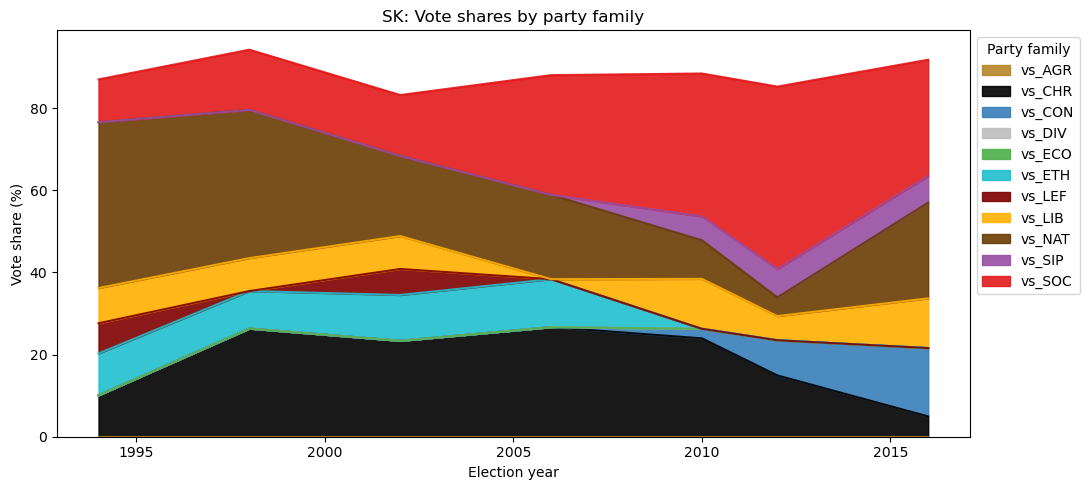

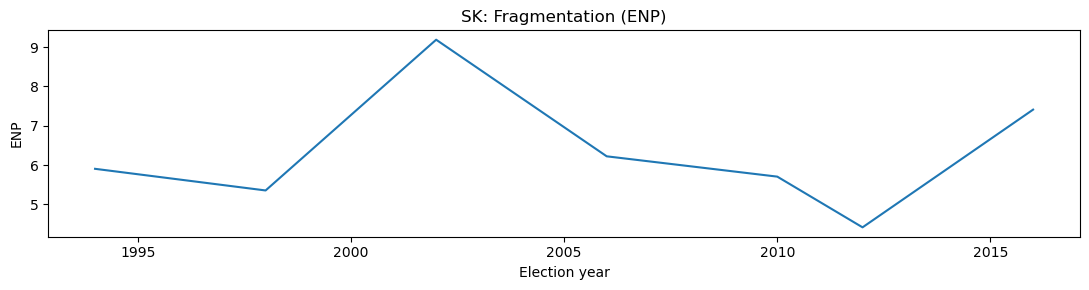

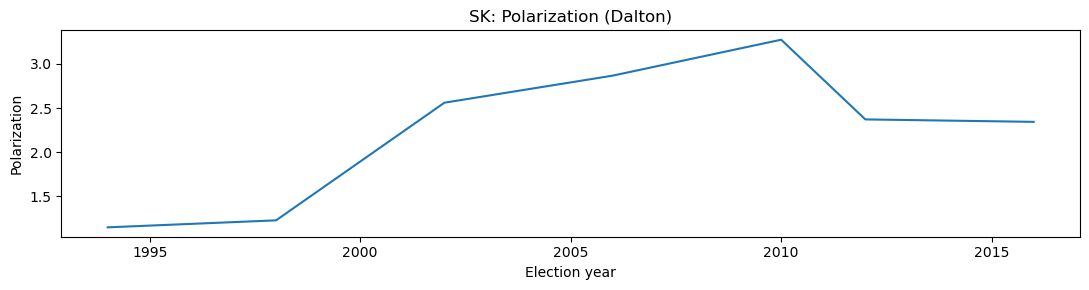


SK — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT      down 1994–2012       -7.81      -35.82
                SOC        up 1994–2012        6.77       34.00
                CHR      down 2006–2016       -7.69      -21.73
                CON        up 2002–2016        4.20       16.64
                NAT        up 2010–2016        6.96       13.92
                CHR        up 1994–2002        6.63       13.26
                ETH      down 2002–2012       -5.71      -11.17
                LIB      down 1998–2006       -4.01       -8.02
                LEF      down 1994–2010       -1.84       -7.35
                SIP        up 2002–2012        3.18        6.90
  fragmentation_enp      down 2002–2012       -1.32       -4.77
  fragmentation_enp        up 2010–2016        0.85        1.70
polarization_dalton        up 1994–2010        0.63        2.12
polarization_dalton      down 2006–2016       -0.36       -0.52


In [31]:
def plot_and_summarize(countries, elections_df, start_year=1993, k=3,thr_vs=0.4, thr_enp=0.15, thr_pol=0.15, top_vs=10, top_enp=2, top_pol=2):
    """
    For each country: plot vote-share stack, fragmentation index & polarization index, then print a compact table of top trend episodes (>= start_year).

    Input:
    countries: list of countries
    elections_df: election data set
    start-year: analyze years restriction
    k: rolling election window size
    thr_*: slope thresholds for detection
    top_*: how many strongest episodes to print per variable type

    Return:
    A dict: geo => per-country episodes table.
    """

    # country & time filter
    countries = [c for c in countries if c in elections_df.index.get_level_values(0)]
    ed = elections_df.loc[(countries, slice(start_year, None)), :]

    # data filter
    fam = [c for c in ed.columns if c.startswith("vs_")]
    cols = fam + ["fragmentation_enp", "polarization_dalton"]

    # compute episodes for one country
    def episodes_for(geo):
        g = ed.loc[geo, cols].sort_index()

        # rolling slope windows
        rows = []
        for col in cols:
            y, yrs = g[col], g.index
            for i in range(len(y)-k+1):
                w = y[i:i+k]
                if np.isnan(w).any(): continue
                # average change per election per (vs x party family, fragmentation and polarization)
                slope = np.polyfit(np.arange(k), w, 1)[0]
                thr = thr_vs if col.startswith("vs_") else (thr_enp if col=="fragmentation_enp" else thr_pol)
                if abs(slope) >= thr: rows.append((col, int(yrs[i]), int(yrs[i+k-1]), float(slope)))
        if not rows: 
            return g, pd.DataFrame(columns=["variable","direction","period","mean_slope","abs_change","pp_change"])

        # convert windows to episodes
        w = pd.DataFrame(rows, columns=["variable","from_year","to_year","slope"]).assign(sign=lambda x: np.sign(x.slope).astype(int))
        w = w.sort_values(["variable","sign","from_year","to_year"])
        prev = w.groupby(["variable","sign"])["to_year"].cummax().shift(fill_value=-10**9)
        w["ep"] = (w["from_year"] > prev).groupby([w["variable"], w["sign"]]).cumsum()

        ep = (w.groupby(["variable","sign","ep"], as_index=False).agg(from_year=("from_year","min"), to_year=("to_year","max"), mean_slope=("slope","mean")))

        # compute absolut change from original time series
        def ch(r):
            s = g[r.variable].dropna().loc[r.from_year:r.to_year]
            if len(s) < 2: return np.nan
            return float(s.iloc[-1] - s.iloc[0])

        ep["abs_change"] = ep.apply(ch, axis=1)
        ep = (ep.dropna(subset=["abs_change"])
                .assign(direction=lambda x: np.where(x.sign > 0, "up", "down"),
                        period=lambda x: x.from_year.astype(str) + "–" + x.to_year.astype(str),
                        mean_slope=lambda x: x.mean_slope.round(2),
                        abs_change=lambda x: x.abs_change.round(2),
                        variable=lambda x: np.where(x.variable.str.startswith("vs_"), x.variable.str[3:], x.variable),
                        impact=lambda x: x.abs_change.abs())
              )

        # select top episodes per country
        vs  = ep[~ep.variable.isin(["fragmentation_enp","polarization_dalton"])].nlargest(top_vs, "impact")
        enp = ep[ep.variable.eq("fragmentation_enp")].nlargest(top_enp, "impact")
        pol = ep[ep.variable.eq("polarization_dalton")].nlargest(top_pol, "impact")
        return g, pd.concat([vs, enp, pol])[["variable","direction","period","mean_slope","abs_change"]]

    # plot & print results
    out = {}
    for geo in countries:
        g, tab = episodes_for(geo)

        g[fam].plot.area(stacked=True, figsize=(11,5), alpha=.9, color=[FAMILY_COLORS[c] for c in fam], title=f"{geo}: Vote shares by party family")
        plt.xlabel("Election year"); plt.ylabel("Vote share (%)")
        plt.legend(loc="upper left", bbox_to_anchor=(1,1), title="Party family")
        plt.tight_layout(); plt.show()

        g["fragmentation_enp"].plot(figsize=(11,3), title=f"{geo}: Fragmentation (ENP)")
        plt.xlabel("Election year"); plt.ylabel("ENP")
        plt.tight_layout(); plt.show()

        g["polarization_dalton"].plot(figsize=(11,3), title=f"{geo}: Polarization (Dalton)")
        plt.xlabel("Election year"); plt.ylabel("Polarization")
        plt.tight_layout(); plt.show()

        print(f"\n{geo} — Most important changes (>= {start_year})")
        print(tab.to_string(index=False))
        out[geo] = tab.reset_index(drop=True)

    return out

# country lists
select_country = ["DE"]
all_countries

# select country and starting year
tables = plot_and_summarize(all_countries, elections_dedup, start_year=1993)